# CS145 Project 2 | There's No Business Like Show Business (Redux)

## Collaborators

Rishubh Thaper (rthaper),
Partner

# Section 1: Project Overview


Last month, Dr. Gru enlisted RT Enterprises to compile some data on how to produce the greatest movie ever made while shooting in San Francisco. He was quite pleased with the results and set his faithful minions to work writing a screenplay. Unfortunately, they ended up fooling around a bit too much and turned out not to be the most creative writers! So when Gru took a look at the plot they had cooked up, he was extremely frustrated. It made no sense! There were animals, aliens, strange blobs made out of various types of desserts, and a story with no protagonist. How could Gru ever direct a hot mess like this?! And how could he even decide where to film?

So he decided to make his and his minions' task easier by adapting a screenplay from a book. At the moment, he doesn't know from where he should pull his source material; in fact, he's not even sure which genre of novel he wants to adapt! All this means MORE data analysis.

Meanwhile, RT Enterprises is growing. The latest round of funding not only enticed investors but brought on a new partner, MW Technologies. The two companies have now joined forces as the formidable unicorn MWRT Systems.

This month, Gru's team has sent a memo to MWRT. They're excited to continue the partnership, but they demand more robust data. Simply collecting information on movies that have already been released is not enough; Gru now needs to know, with a high degree of confidence, whether this quest that he has embarked on will pay off to the extent that he wants. Besides San Francisco, where else should he film, perhaps internationally? How much should he spend, and how will his budget translate into revenue? And now that he has decided on adapting a book for his screenplay, what kinds of qualities should his source material have? This calls for some machine learning capabilities, and fortunately, MW Technologies boasts just the right tools for it.

So, in this latest installment of the partnership, Gru has a few more urgent questions:

1. *How does the MOVING 5-YEAR AVERAGE RATING of ADAPTED SCREENPLAYS compare with that of ORIGINAL ONES? Is it worth it to adapt a feature film from fictional source material?*

2. *What are the top ACTOR-DIRECTOR PAIRINGS in terms of RETURN ON INVESTMENT and RATING?*

3. *What are the top FLOPS and SLEEPER HITS with a SMALL BUDGET?*

4. *How does the rating of a movie CHANGE WITH TIME? Which movies receive a NOSTALGIA BUMP, and which get a HYPE BACKLASH after they have been out for a while?*

5. *How does a movies RETURN ON INVESTMENT compare to its EXPECTED every DECADE?*

And finally, now that Gru is aware that MWRT has implemented machine learning capabilities, he is excited to find out:

6. *Which BOOKS, previously unadapted into feature films, are WORTH ADAPTING right now?*

7. *How does a movie's CAST, CREW, BUDGET, THEME, AUDIENCE APPEAL, as well as the CURRENT MACROECONOMIC CLIMATE of the UNITED STATES, influence the movie's chances for box office and critical success?*

This last business decision will require some NLP! As you will see, we will employ Google's Vertex AI to send a batch inference request to Gemini 2.5 Flash to evaluate every movie as either "family-friendly" or not to determine its audience appeal. Our hypothesis is that family-friendly movies perform better, so Gru may have to abandon his adult filmmaking ambitions once and for all.

We are very excited to get going on all these important questions, so let's dive right in.

Table Sizes and Relationships
-----------------------------

Recall that we mainly worked with the imdb dataset in BigQuery's public data. This contains the following the tables:
* name_basics: 836.02 MB, 14.7 million rows
* reviews: 132.2 MB, 100,000 rows
* title_akas: 2.6 GB, 53.2 million rows
* title_basics: 1.08 GB, 11.9 million rows
* title_crew: 368.26 MB, 11.9 million rows
* title_episode: 312.69 MB, 9.2 million rows
* title_principals: 4.26 GB, 95.1 million rows
* title_ratings: 42.57 MB, 1.6 million rows

For convenience, we reproduce our analysis of each table from Project 1 here.

None of the tables we are using have primary keys because they are allowed to have NULL values and thus may contain duplicates. Because NULL does not uniquely identify each row, such a key cannot be considered primary. This is a bit strange because every principal has a name ID, and every title feature has a title ID; these columns are usually not NULL. However, the table allows even these fields to take on NULl values.

Let us now walk through, in depth, the schema for each of the tables we will query, and discuss important primary and foreign keys:

1. imdb.name_basics: Here, the keys we will be using are nconst (STRING), primary_name (STRING), birth_year (INTEGER), and death_year (INTEGER). We will mainly be exploiting nconst to join to other tables and primary_name to access the figure's actual name; occasionally, we will filter for actors who are currently alive by including "WHERE death_year IS NULL" in our query.

2. imdb.title_basics: Here, the keys are tconst (STRING), title_type (STRING), primary_title (STRING), start_year (INTEGER), genres (STRING), and is_adult (INTEGER). The first of these, tconst, will be very important for JOINs to other tables involving title information, as this is a unique ID for every title. Since Gru is mainly interested in movies, we will frequently filtered out title_type by "movie." And when we want to restrict to more recent movies, we'll filter the start_year. For queries grouping by genre, the genres column will be important, and finally -- as Gru can be a bit raunchy at times -- we will play around with the is_adult flag.

3. imdb.reviews: The only non-foreign key we'll be using from this table is label. This is an NLP-based quality (positive, negative, or neutral) assigned to each IMDB review. On the other hand, title is a foreign key that will JOIN to the title_basics table on primary_title.

4. imdb.title_principals: There is one key in this table -- category -- which refers to the member's role on the feature (actor, writer, producer, director, etc.). The other two keys we will reference are foreign keys -- nconst and tconst -- JOINing to the title_basics and name_basics tables.

5. imdb.title_ratings: The average_rating key will be extremely helpful to find loved or hated films, while -- again -- the tconst foreign key will help JOIN to the title_basics table.

6. imdb.title_akas: This table contains extra demographic information about each title, and as a result, we will occasionally use the region and langague keys to filter for American movies in English. The title_id is, in fact, a foreign key allowing us to -- once again -- JOIN to the title_basics table.

The overall crux of the methodology is to take advantage of the tconst, nconst, and title keys which are referenced across multiple tables to join them together so that we can correlate actors to movies to reviews to ratings.

Now, in Project 1, we also used the san_francisco_film_locations dataset to join to the imdb tables. In Project 2, we'll opt for a different direction, as we will be answering questions about budget, revenue, and book-to-movie adaptations as opposed to filming locations.

To that end, we will pull datasets from outside sources, rather than restricting ourselves to BigQuery's public data. The first of these is the massive Kaggle dataset called "The Movies" (linked at https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset). This contains information on all movies released on or before July 2017, so slightly dated. However, for the purposes of ML modeling, it should not make a difference, as there is a significant amount of training data available for predictions that are still relevant today.


Importantly, the data is scraped from The Movies Database (TMDB), which is a user-updated database of movies similar to IMDB.

Next, we scrape Wikipedia for feature film adaptations of fictional works, adjoin it to a GoodReads metadata dataset on the best books ever from Kaggle (https://www.kaggle.com/datasets/thedevastator/comprehensive-overview-of-52478-goodreads-best-b), and compile everything into our own small table in BigQuery.

Now, Gru's team is also very concerned with the state of the economy: if they are going to shell out for this big production, it better be worth it. To that end, we have gathered macroeconomic data from Federal Reserve Bank of St. Louis (FRED) -- including real GDP, GNI, CPI, disposable personal income, expenditure, and the federal funds rate. Most of the data is observed monthly starting from January 1947 all the way to September 2025. The datasets can be found at https://fred.stlouisfed.org/.

Finally, the piece de resistance of the project will be an ML model that predicts whether a movie will be a hit given an array of indicators, and to build the feature set as exhaustively as possible, we need more information than just what is on BigQuery's public IMDB data. We have found the Letterboxd dataset on Kaggle, which contains information on studios, languages, actors, crew members, themes, genres, and release dates for over 950,000 different movies. The dataset is 24 GB large, and we will join multiple pieces of it to our current collection to perform more elaborate queries. It is located at https://www.kaggle.com/datasets/gsimonx37/letterboxd.


In [3]:
# Run this cell to authenticate yourself to BigQuery
import os
from google.colab import auth
auth.authenticate_user() # make sure to "Select All" when authenticating
project_id = os.getenv("GCP_PROJECT_ID", "<your-gcp-project-id>")

In [4]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

# Section 2: Pick and Upload a New Table


As mentioned in section 1, the new dataset we will be harnessing for this project is Kaggle's "The Movies Dataset." Let us walk through each of the two tables we will be using and discuss how they fit into the data we already have:

* movies_metadata: The main metadata table. It contains information on over 45,000 movies featured in the Full Movielens Dataset (Movielens is an online movie recommendation service). It has 45,458 rows with a total size of 19.02 MB. There are no primary keys in this table because they are allowed to be null-able. The JOIN potential here lies in the key imdb_id, which is the same field as tconst from the BigQuery imdb dataset. At the same time, we have access to a wealth of additional ratings and reviews via TMDB's repository, as well as budget, revenue, and production information.

* ratings: Contains over 26 million ratings from over 270,000 users for a total size of 709.55 MB.

The other dataset on book-to-movie adaptations is one that we have manually put together. It was done in three steps: first, we scraped the Wikipedia collection "List of Fiction Works Adapted Into Feature Films" for ALL movies adapted from a fictional primary source. Such works include, for example, Francis Ford Coppola's "The Godfather" as well as Alfred Hitchcock's "The Lady Vanishes" (which was adapted from a novel of a different name -- *The Wheel Spins*). Next, we downloaded Kaggle's Goodreads Book Dataset With User Rating 2M, which contains metadata for over 1 million books on Goodreads along with their user ratings. This dataset was updated every 2 days until GoodReads discontinued providing authorized API keys in 2021. Finally -- and this was the most difficult part -- we employed a technique called "fuzzy matching" to match the GoodReads book titles with their respective Wikipedia entries. Because none of these datasets -- neither our scraped collection nor the Kaggle tables -- had a unique ID key (actually, the GoodReads dataset does include each book's unique ISBN but Wikipedia does not, so it was impossible to join the datasets on this key). Fuzzy matching uses various distance functions (like the Levenshtein distance) to compare how similar two strings are, and our algorithm adopted a tiered method by first comparing book titles, rejecting all those below a score of 60% and accepting those having a score of at least 80%. For those in between the two thresholds, we advanced to comparing authors, accepting them if this match was strong. The point was that we didn't want strange matches like Donald Westlake's suspense novel The Ax being paired with The A-Z Guide to Herbal Remedies (and yes, with our first algorithm, this match actually did happen!).

The data engineering paradigms were designed by us, and the code to execute them was generated with the help of ChatGPT and Claude. Below is the complete Python ETL pipeline that we employed on our local machine. It took over half an hour to run due to the massive size of the GoodReads dataset, and in hindsight, we should have used BigQuery SQL's Levenshtein distance function to simply do the entire job on the cloud, but once the dataset was compiled locally, it didn't really matter what the memory cost was.

The final result of all of this data engineering was a curated dataset:

* book_to_movie_adaptions: 2,809 rows encompassing 532.69 KB with no primary keys. However, we can join it on film and imdb.title_basics.primary_title effectively to compare book ratings to their respective adaptation's ratings, etc.

We use it in conjunction with Kaggle's Goodreads Best Books Ever:

* goodreads_best_books_ever: 52,478 rows totalling 63.59 MB, with no primary keys (though book_id is a unique, NULLable identifier) and including columns like series, author, rating, publisher, likedPercentage, and awards. If an author is a Goodreads author, this is indicated in parentheses after the author name, so we can use regular expression matching to extract this important bit of information.

Moving on, we downloaded economic data from the Federal Reserve, which we strung together into another self-made dataset:
* fred_data: 314 rows encompassing 14 KB; this is a very small table that just contains observations for various macroeconomic indicators like gross domestic product and personal consumer expenditure.

And finally, the Letterboxd dataset is the heaviest of all of them, and we use mutiple portions of it for our analysis. These were downloaded individually from Kaggle and then uploaded to BigQuery as:
* letterboxd_movies: 941,597 rows encompassing 246.47 MB; the most important key is id, which is a foreign key that can be used to intra-join all tables within this dataset to each other (to join this externally to our existing IMDB dataset, we'll have to use the movie titles). Other important columns include name, date, tagline, and description (which we use for sentiment analysis later in the project).
* letterboxd_actors: 5.798,450 rows encompassing 188.88 MB; the movie id and the actor's name is the only key we will be using from here.
* letterboxd_crew: 4,720,183 rows encompassing 158.98 MB; again, movie id and the crew member's name will be used.
* letterboxd_themes: 125,641 rows encompassing 5.25 MB; not all movies have definite themes associated to them, but the ones that do will be used for our ML model to predict whether, for example, family-friendly movies do better.
* letterboxd_studios: 679,283 rows encompassing 17.47 MB
* letterboxd_releases: 1,332,782 rows encompassing 45.68 MB
* letterboxd_genres: 1,046,849 rows encompassing 17.1 MB
* letterboxd_languages: 1,038,762 rows encompassing 28.25 MB; the language column will be useful to filter for English movies.

The setup of the Letterboxd dataset is essentially the same as our current IMDB one, but with a wealth of more data like themes, crew members, release information, and a more comprehensive list of actors.



In [ ]:
# No need to run this cell; it is simply included for completeness and was run on our local machine anyway!
import re
import time
import requests
import pandas as pd
import glob
import os
from io import StringIO
from rapidfuzz import process, fuzz

# ---------------------------------------------
# CONFIG
# ---------------------------------------------

WIKI_URLS = [
    "https://en.wikipedia.org/wiki/List_of_fiction_works_made_into_feature_films_%280%E2%80%939%2C_A%E2%80%93C%29",
    "https://en.wikipedia.org/wiki/List_of_fiction_works_made_into_feature_films_%28D%E2%80%93J%29",
    "https://en.wikipedia.org/wiki/List_of_fiction_works_made_into_feature_films_%28K%E2%80%93R%29",
    "https://en.wikipedia.org/wiki/List_of_fiction_works_made_into_feature_films_%28S%E2%80%93Z%29",
    "https://en.wikipedia.org/wiki/List_of_children%27s_books_made_into_feature_films",
]

GOODREADS_ARCHIVE_DIR = "archive"
OUTPUT_PATH = "adaptations_goodreads_matched.csv"

USER_AGENT = {
    "User-Agent": (
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/119.0.0.0 Safari/537.36"
    )
}

# ---------------------------------------------
# NORMALIZATION HELPERS
# ---------------------------------------------

def normalize_title(t):
    if pd.isna(t):
        return ""
    t = t.lower()
    # Remove content in parentheses but keep the title intact
    t = re.sub(r'\([^)]*\)', '', t)
    # Only remove subtitles after colon (keep hyphens as they're often part of the title)
    t = re.sub(r':.*', '', t)
    # Remove leading articles (the, a, an)
    t = re.sub(r'^(the|a|an)\s+', '', t)
    # Keep apostrophes and basic punctuation, just remove special chars
    t = re.sub(r'[^a-z0-9\s\'\-]', '', t)
    t = re.sub(r'\s+', ' ', t)
    return t.strip()

def normalize_author(a):
    if pd.isna(a):
        return ""
    a = a.lower()
    a = re.sub(r'[^a-z0-9 ]', '', a)
    a = re.sub(r'\s+', ' ', a)
    return a.strip()

# ---------------------------------------------
# AUTHOR EXTRACTION FROM WIKIPEDIA BOOK STRINGS
# ---------------------------------------------

def extract_title_and_author(raw):
    """
    Extracts (title, author) from Wikipedia 'book' column entries.
    Main format: Title (year), Author
    """
    if pd.isna(raw):
        return raw, None

    text = raw.strip()

    # Primary pattern: Title (year), Author
    # This is the most common format in Wikipedia tables
    m = re.match(r'^"?([^"(]+)\s*\([^)]*\)\s*,\s*(.+?)"?$', text)
    if m:
        title = m.group(1).strip()
        author = m.group(2).strip()
        # Clean up author - remove any remaining parenthetical info
        author = re.sub(r'\([^)]*\)', '', author).strip()
        return title, author

    # Fallback: Title, Author (no year in parentheses)
    m = re.match(r'^"?([^,]+),\s*([^"]+?)"?$', text)
    if m:
        title = m.group(1).strip()
        author = m.group(2).strip()
        # Don't accept if "author" looks like a year or is too short
        if not re.match(r'^\d{4}', author) and len(author) > 3:
            author = re.sub(r'\([^)]*\)', '', author).strip()
            return title, author

    # If no pattern matches, return the raw text with no author
    return text, None

# ---------------------------------------------
# STEP 1 — SCRAPE WIKIPEDIA
# ---------------------------------------------

def scrape_wikipedia():
    print(">>> Scraping Wikipedia adaptation tables...")
    frames = []

    for url in WIKI_URLS:
        print(f"[INFO] Fetching: {url}")
        resp = requests.get(url, headers=USER_AGENT)
        html = resp.text
        try:
            tables = pd.read_html(StringIO(html))
        except ValueError:
            print(f"[WARN] No tables on {url}")
            continue

        for df in tables:
            if len(df.columns) < 2 or len(df) < 2:
                continue

            columns_str = " ".join([c.lower().strip() for c in df.columns.astype(str)])
            # Look for "fiction work" and "film adaptation" columns
            if ("fiction" in columns_str and "work" in columns_str) and ("film" in columns_str and "adaptation" in columns_str):

                new_cols = []
                for c in df.columns:
                    cleaned = c.lower().strip().replace(" ", "_").replace("(", "").replace(")", "")
                    # Rename "fiction_work_s" to "book" and "film_adaptation_s" to "film"
                    if "fiction" in cleaned and "work" in cleaned:
                        cleaned = "book"
                    elif "film" in cleaned and "adaptation" in cleaned:
                        cleaned = "film"
                    new_cols.append(cleaned)
                df.columns = new_cols

                if "book" in df.columns and "film" in df.columns:
                    frames.append(df)

    if not frames:
        raise RuntimeError("No adaptation tables found.")

    adapt = pd.concat(frames, ignore_index=True)

    # Remove citations [1], [2], etc.
    for col in adapt.columns:
        if adapt[col].dtype == "object":
            adapt[col] = adapt[col].astype(str).str.replace(r"\[.*?\]", "", regex=True).str.strip()

    # Keep only useful columns
    keep_cols = [c for c in ["book", "author", "film", "year"] if c in adapt.columns]
    adapt = adapt[keep_cols]

    print(f"[INFO] Scraped {len(adapt)} raw adaptation rows.")

    # ---------------------------------------------
    # AUTHOR EXTRACTION HERE
    # ---------------------------------------------
    extracted_titles = []
    extracted_authors = []

    for raw_book in adapt["book"]:
        title, author = extract_title_and_author(raw_book)
        extracted_titles.append(title)
        extracted_authors.append(author)

    adapt["book_original"] = adapt["book"]
    adapt["book"] = extracted_titles

    # If table already had an author column, only fill missing ones
    if "author" in adapt.columns:
        adapt["author"] = adapt["author"].fillna(extracted_authors)
    else:
        adapt["author"] = extracted_authors

    # Show some examples
    print("\n[INFO] Sample extractions:")
    for i in range(min(5, len(adapt))):
        print(f"  '{adapt['book_original'].iloc[i][:60]}...'")
        print(f"  -> Title: '{adapt['book'].iloc[i]}', Author: '{adapt['author'].iloc[i]}'")

    adapt = adapt.dropna(subset=["book", "film"])

    print(f"[INFO] After author extraction: {len(adapt)} rows.")
    return adapt

# ---------------------------------------------
# STEP 2 — LOAD GOODREADS FROM ARCHIVE
# ---------------------------------------------

def load_goodreads_from_archive():
    print(">>> Loading Goodreads dataset from archive directory...")

    csv_files = sorted(glob.glob(os.path.join(GOODREADS_ARCHIVE_DIR, "book*.csv")))

    if not csv_files:
        raise RuntimeError(f"No book*.csv files found in {GOODREADS_ARCHIVE_DIR}")

    print(f"[INFO] Found {len(csv_files)} CSV files to load")

    all_books = []

    for i, csv_file in enumerate(csv_files, 1):
        print(f"[INFO] Loading file {i}/{len(csv_files)}: {os.path.basename(csv_file)}")
        try:
            df = pd.read_csv(csv_file)
            df.columns = [c.lower().strip().replace(" ", "_") for c in df.columns]

            # Keep only necessary columns to save memory
            keep_cols = ['id', 'name', 'authors', 'rating', 'isbn', 'publisher', 'publishyear', 'language']
            available_cols = [c for c in keep_cols if c in df.columns]
            df = df[available_cols]

            # Normalize
            df["title_norm"] = df["name"].astype(str).apply(normalize_title)
            df["author_norm"] = df["authors"].astype(str).apply(normalize_author)

            all_books.append(df)
        except Exception as e:
            print(f"[WARN] Error loading {csv_file}: {e}")
            continue

    gr = pd.concat(all_books, ignore_index=True)
    print(f"[INFO] Total Goodreads books loaded: {len(gr):,}")

    return gr

# ---------------------------------------------
# TIERED FUZZY MATCHING
# ---------------------------------------------

def tiered_accept(title_score, author_score, has_author):
    # If we extracted an author, require a good author match
    if has_author:
        if title_score >= 85 and author_score >= 75:
            return True, "strong"
        if title_score >= 80 and author_score >= 70:
            return True, "medium"
        # Reject if author doesn't match well
        return False, "none"
    else:
        # If no author extracted, require very high title match
        if title_score >= 95:
            return True, "strong"
        return False, "none"

def best_match_title_and_author(title_norm, author_norm, goodreads):
    has_author = author_norm != "" and author_norm != "none"

    # First: try title match across entire dataset
    match_result = process.extractOne(
        title_norm,
        goodreads["title_norm"].tolist(),
        scorer=fuzz.token_sort_ratio
    )

    if match_result is None or match_result[1] < 70:
        return None, 0 if match_result is None else match_result[1], None, "none"

    match_title_norm, title_score, idx = match_result
    gr_row = goodreads.iloc[idx]
    author_score = None

    if has_author:
        author_score = fuzz.token_sort_ratio(author_norm, gr_row["author_norm"])

    accept, tier = tiered_accept(title_score, author_score, has_author)
    if accept:
        return gr_row, title_score, author_score, tier

    # Second: if we have an author, filter by author first then search titles
    if has_author:
        filtered = goodreads[
            goodreads["author_norm"].apply(lambda a: fuzz.token_sort_ratio(a, author_norm) >= 70)
        ]
        if not filtered.empty:
            match2_result = process.extractOne(
                title_norm,
                filtered["title_norm"].tolist(),
                scorer=fuzz.token_sort_ratio
            )
            if match2_result is not None:
                match2, score2, idx2 = match2_result
                row2 = filtered.iloc[idx2]
                author2 = fuzz.token_sort_ratio(author_norm, row2["author_norm"])
                accept2, tier2 = tiered_accept(score2, author2, has_author)
                if accept2:
                    return row2, score2, author2, tier2

    return None, title_score, author_score, "none"

def fuzzy_match_adaptations(adapt, goodreads):
    print(">>> Performing fuzzy matching with tiered thresholds...")

    adapt = adapt.copy()
    adapt["book_norm"] = adapt["book"].astype(str).apply(normalize_title)
    adapt["author_norm"] = adapt["author"].astype(str).apply(normalize_author)

    rows = []

    for i, row in adapt.iterrows():
        bn = row["book_norm"]
        an = row["author_norm"]

        gr_row, title_score, author_score, tier = best_match_title_and_author(bn, an, goodreads)

        if gr_row is None:
            rows.append({
                **row,
                "match_success": False,
                "match_tier": "none",
                "gr_id": None,
                "gr_title": None,
                "gr_avg_rating": None,
                "gr_ratings_count": None,
                "title_score": title_score,
                "author_score": author_score
            })
        else:
            rows.append({
                **row,
                "match_success": True,
                "match_tier": tier,
                "gr_id": gr_row.get("id"),
                "gr_title": gr_row.get("name"),
                "gr_author": gr_row.get("authors"),
                "gr_isbn": gr_row.get("isbn"),
                "gr_publisher": gr_row.get("publisher"),
                "gr_publication_year": gr_row.get("publishyear"),
                "gr_language": gr_row.get("language"),
                "gr_avg_rating": gr_row.get("rating"),
                "title_score": title_score,
                "author_score": author_score
            })

        if (i + 1) % 50 == 0:
            print(f"[INFO] Processed {i+1}/{len(adapt)} rows...")

    df = pd.DataFrame(rows)
    print(df["match_tier"].value_counts())
    return df

# ---------------------------------------------
# MAIN
# ---------------------------------------------

def main():
    adapt = scrape_wikipedia()
    gr = load_goodreads_from_archive()
    matched = fuzzy_match_adaptations(adapt, gr)
    matched.to_csv(OUTPUT_PATH, index=False)
    print(f"\n>>> DONE! Saved to {OUTPUT_PATH}")

if __name__ == "__main__":
    main()

## Join Query 1

We'll begin simply, but still keenly, by exploring the JOIN behavior of our new dataset. Namely, let us use the new columns provided by movies_metadata to generate some new, previously unexplored insights.

The first JOIN query ranks production countries by average IMDB and TMDB ratings. Since the production_countries column is a JSON-formatted string (which really functions as a dictionary or array), we use an UNNEST operation to extract each individual production country and explode the array to rank each one.

In [3]:
# join query 1
%%bigquery --project $project_id
WITH exploded AS (
  SELECT
    m.imdb_id,
    -- Extract the country name from the JSON array of production_countries
    JSON_VALUE(c, '$.name') AS country_name,
    -- Select TMDB vote average as average_tmdb_rating
    m.vote_average as average_tmdb_rating
  FROM `cs-145-project-fall-25.uploaded_movie_data.movies_metadata` m
  -- Unnest the JSON array of production_countries to get individual countries
  CROSS JOIN UNNEST(JSON_EXTRACT_ARRAY(m.production_countries)) AS c
)
SELECT
  country_name,
  -- Calculate the average IMDB rating for each country
  AVG(r.average_rating) AS avg_imdb_rating,
  -- Calculate the average TMDB rating for each country
  AVG(e.average_tmdb_rating) AS avg_tmdb_rating,
  -- Count the number of movies for each country
  COUNT(*) AS num_movies
FROM exploded e
-- Join with the IMDB title_ratings table using imdb_id and tconst
JOIN `bigquery-public-data.imdb.title_ratings` r
  ON e.imdb_id = r.tconst
GROUP BY e.country_name
-- Filter for countries with at least 50 movies to ensure data significance
HAVING COUNT(*) >= 50
-- Order the results by average IMDB rating (descending) then average TMDB rating (descending)
ORDER BY avg_imdb_rating DESC,avg_tmdb_rating DESC

Query is running:   0%|          |

Downloading:   0%|          |

,country_name,avg_imdb_rating,avg_tmdb_rating,num_movies
0,Iran,7.091509,6.157547,106
1,Turkey,6.920000,6.582424,165
2,Serbia,6.898113,6.123585,106
3,Czech Republic,6.849519,6.152885,208
4,India,6.776634,5.936925,826
5,Taiwan,6.748062,6.615504,129
6,Hungary,6.745714,5.764000,175
7,Japan,6.705603,6.169123,1642
8,Iceland,6.658824,6.092647,68
9,Greece,6.656213,6.019527,169


## Join Query 2

Next, we explore the other major part of this escapade, which is comparing *books* to their *film* adaptations.

Our JOIN query calculates the percentage difference between a book's average GoodReads rating and each of its film adaptations' IMDB ratings to see which movies were appreciated more than their source material.

We find that Die Hard, based on the action thriller novel *Nothing Lasts Forever*, is one of the top performing movie adaptations relative to its source material! Perhaps Gru should check it out to see how he can best adapt his source material.

In [4]:
# join query 2
%%bigquery --project $project_id
WITH book_movie_ratings AS (
  SELECT
    bma.gr_title AS book_title,
    bma.book_year AS book_year,
    bma.film_title AS film_title,
    bma.film_year AS film_year,
    tr.average_rating AS adaptation_rating,
    bma.gr_avg_rating AS avg_source_rating
  FROM `cs-145-project-fall-25.uploaded_movie_data.book_to_movie_adaptations` bma
  JOIN `bigquery-public-data.imdb.title_basics` tb
    ON bma.film_title = tb.primary_title AND bma.film_year = tb.start_year
  JOIN `bigquery-public-data.imdb.title_ratings` tr
    ON tb.tconst = tr.tconst
  WHERE bma.gr_avg_rating IS NOT NULL
    AND tr.num_votes >= 500
    AND bma.book_year IS NOT NULL
  GROUP BY
    book_title, book_year, film_title, film_year,
    adaptation_rating, avg_source_rating
)

SELECT
  book_title,
  book_year,
  film_title,
  film_year,
  adaptation_rating / 2.0 AS normalized_adaptation_rating,
  avg_source_rating,
  ROUND(
    SAFE_DIVIDE((adaptation_rating / 2.0) - avg_source_rating, avg_source_rating) * 100,
    2
  ) AS diff
FROM book_movie_ratings
ORDER BY diff DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,book_title,book_year,film_title,film_year,normalized_adaptation_rating,avg_source_rating,diff
0,"Body: Bones, Muscle, Blood and Other Body Bits",1983,The Body,2001,4.85,4.05,19.75
1,The Clansman,1905,The Birth of a Nation,1915,3.05,2.64,15.53
2,"Nothing Lasts Forever (Die Hard, #1)",1979,Die Hard,1988,4.10,3.55,15.49
3,About Schmidt,1996,About Schmidt,2002,3.60,3.20,12.50
4,The Scarlet Letter,1850,The Scarlet Letter,1926,3.80,3.40,11.76
...,...,...,...,...,...,...,...
1413,Twenty Thousand Leagues Under the Seas (Little...,1870,"30,000 Leagues Under the Sea",2007,1.30,4.50,-71.11
1414,The War Of The Worlds,1898,War of the Worlds 2: The Next Wave,2008,1.05,3.82,-72.51
1415,Dracula,1897,Dracula 3000,2004,1.05,3.99,-73.68
1416,Dracula,1897,Die Hard Dracula,1998,0.90,3.99,-77.44


## Join Query 3

Finally, we employ some joins with our largest dataset, Letterboxd. An interesting nontrivial question to ask is: which movies rated better than the average rating expected from the studio that produced them? This uses a CTE and multiple JOINs with letterboxd_movies, letterboxd_studios, letterboxd_releases, imdb.title_basics, and imdb.title_ratings.

Importantly, the logic for these joins will figure prominently when creating the training table for our movie hit prediction ML model later on. The main caveat is that since the Letterboxd dataset does not have a unique identifying foreign key that can adjoin to the IMDB dataset, we will have to join by movie title. But many movies have the same title! So to get around this, we will join on multiple conditions like release_year to be as sure as possible that we are joining correctly.

In [5]:
# join query 3
%%bigquery --project $project_id

WITH studio_ratings AS
(
  SELECT
    ls.studio, -- Select the studio name
    AVG(tr.average_rating) AS average_studio_rating -- Calculate the average rating for movies from this studio
  FROM `cs-145-project-fall-25.uploaded_movie_data.letterboxd_studios` ls -- Start with the letterboxd_studios table
  JOIN `cs-145-project-fall-25.uploaded_movie_data.letterboxd_movies` lm ON ls.id = lm.id -- Join with letterboxd_movies on ID to link studios to movies
  JOIN `cs-145-project-fall-25.uploaded_movie_data.letterboxd_releases` lr on lm.id = lr.id -- Join with letterboxd_releases on ID to get release details
  -- Join with IMDb title_basics using movie name and release year to find corresponding IMDb entries
  JOIN `bigquery-public-data.imdb.title_basics` tb ON lm.name = tb.primary_title AND tb.start_year = EXTRACT(YEAR FROM lr.date)
  JOIN `bigquery-public-data.imdb.title_ratings` tr ON tb.tconst = tr.tconst -- Join with IMDb title_ratings to get the average rating
  WHERE tb.title_type = 'movie' -- Filter for entries that are movies
  GROUP BY ls.studio -- Group by studio to calculate the average rating per studio
)

-- Main query to select movies that rated better than their studio's average rating
SELECT
  lm.name,
  lr.date,
  ls.studio,
  tr.average_rating,
  average_studio_rating
FROM `cs-145-project-fall-25.uploaded_movie_data.letterboxd_studios` ls
JOIN `cs-145-project-fall-25.uploaded_movie_data.letterboxd_movies` lm ON ls.id = lm.id
JOIN `cs-145-project-fall-25.uploaded_movie_data.letterboxd_releases` lr on lm.id = lr.id
JOIN `bigquery-public-data.imdb.title_basics` tb ON lm.name = tb.primary_title AND tb.start_year = EXTRACT(YEAR FROM lr.date)
JOIN `bigquery-public-data.imdb.title_ratings` tr ON tb.tconst = tr.tconst
JOIN studio_ratings ON ls.studio = studio_ratings.studio
WHERE tr.average_rating > average_studio_rating -- Filter for movies whose rating is higher than their studio's average
ORDER BY tr.average_rating - average_studio_rating DESC -- Order the results by the difference (highest difference first)


Query is running:   0%|          |

Downloading:   0%|          |

,name,date,studio,average_rating,average_studio_rating
0,Jeepers Creepers: Reborn,2024-01-25,Ink Pine Media,10.0,2.600000
1,Jeepers Creepers: Reborn,2024-01-25,Orwo Studios (US),10.0,2.969231
2,The Fool,2024-04-14,Stolen Thunder Pictures,10.0,3.100000
3,Virus,1996-12-10,Spill Film Productions Ltd.,10.0,3.100000
4,Dude in the Headlights,2016-02-20,Ambition Pictures,9.3,2.600000
...,...,...,...,...,...
792078,The Apocalypse,2002-12-10,NCRV,6.2,6.200000
792079,Last Night,2014-01-01,American Filmmaker,5.7,5.700000
792080,Dixie Dynamite,1976-05-13,Dimension Pictures,5.2,5.200000
792081,Door Mouse,2022-09-09,Independent Edge Films,5.5,5.500000


# Section 3: SQL + Visualizations and Data Exploration


Visualizations
* Query #1 [CTE, Window Function]: Compute the Moving 5-Year Average IMDB Ratings of Original and Adapted Screenplays
* Query #2 [CTE, Correlated Subqueries]: Determine how Each Genre Rates Per Decade Compared to Expected
* Query #6 [CTEs, Bucketing]: Genre Performance Over Time
* Query #7 [CTEs, Window Functions]: How does a Movie's Return on Investment (ROI) Compared to its Expected Every Decade?
* Query #8 [CTEs, Window Functions]: Is There Any Correlation Between GDP Change and Movie Revenue Change Per Year?
* Query #9 [CTEs, Window Functions]: Is There Any Correlation Between Consumer Sentiment and Movie Revenue Change Per Year?


## Query #1 [CTE, Window Function]: Compute the Moving 5-Year Average IMDB Ratings of Original and Adapted Screenplays

How do adapted screenplays perform versus nonadapted ones? For the sake of simplicity, we'll assume that an adaptation is one that is scraped off the Wikipedia lists, namely that its source material is a work of fiction. Of course, this is a limiting assumption, as so many movies are adapted from material that is not neccessarily a known fictional work, but it should not make too much of a difference. In addition, the Wikipedia list is fairly exhaustive.

This query calculates the five-year moving average of IMDB ratings of adapted and non-adapted screenplays and plots them in a line graph to show the difference. The reason a five-year average is preferred over just a single year is that it more accurately represents the current trend.



In [6]:
# join query 2
%%bigquery --project $project_id
-- Define a Common Table Expression (CTE) to select non-adaptation movies from IMDB
WITH imdb_movies AS (
  SELECT
    tb.primary_title AS title,
    SAFE_CAST(tb.start_year AS INT64) AS year,
    tr.average_rating AS rating
  FROM `bigquery-public-data.imdb.title_basics` tb
  JOIN `bigquery-public-data.imdb.title_ratings` tr
    ON tb.tconst = tr.tconst
  WHERE tb.title_type = 'movie'
    AND SAFE_CAST(tb.start_year AS INT64) BETWEEN 1960 AND 2024
),

-- Define a CTE to select movie adaptations from the uploaded dataset
adaptation_movies AS (
  SELECT
    bma.film_title AS title,
    bma.film_year AS year,
    tr.average_rating AS rating
  FROM `cs-145-project-fall-25.uploaded_movie_data.book_to_movie_adaptations` bma
  JOIN `bigquery-public-data.imdb.title_basics` as tb
    ON bma.film_title = tb.primary_title AND bma.film_year = tb.start_year
  JOIN `bigquery-public-data.imdb.title_ratings` tr
    ON tb.tconst = tr.tconst
  WHERE bma.film_year BETWEEN 1960 AND 2024
),

-- Combine both adaptation and non-adaptation movies into a single CTE
combined AS (
  SELECT
    title,
    year,
    rating,
    0 AS is_adaptation -- 0 for non-adaptation movies
  FROM imdb_movies
  UNION ALL
  SELECT
    title,
    year,
    rating,
    1 AS is_adaptation -- 1 for adaptation movies
  FROM adaptation_movies
),

-- Calculate the yearly average rating for both adaptation and non-adaptation movies
yearly_stats AS (
  SELECT
    year,
    is_adaptation,
    AVG(rating) AS avg_rating
  FROM combined
  GROUP BY year, is_adaptation
),

-- Calculate a 5-year moving average for the ratings using a window function
smoothed AS (
  SELECT
    year,
    is_adaptation,
    avg_rating,
    AVG(avg_rating) OVER (
      PARTITION BY is_adaptation
      ORDER BY year
      ROWS BETWEEN 2 PRECEDING AND 2 FOLLOWING -- 5-year window (2 before, current, 2 after)
    ) AS moving_avg_rating
  FROM yearly_stats
)

-- Final selection of year, adaptation status, and the calculated moving average rating
SELECT
  year,
  is_adaptation,
  moving_avg_rating
FROM smoothed
ORDER BY year, is_adaptation;

Query is running:   0%|          |

Downloading:   0%|          |

,year,is_adaptation,moving_avg_rating
0,1960,0,6.145354
1,1960,1,6.699311
2,1961,0,6.140077
3,1961,1,6.724484
4,1962,0,6.126980
...,...,...,...
125,2022,1,6.238929
126,2023,0,6.309541
127,2023,1,6.188244
128,2024,0,6.348507


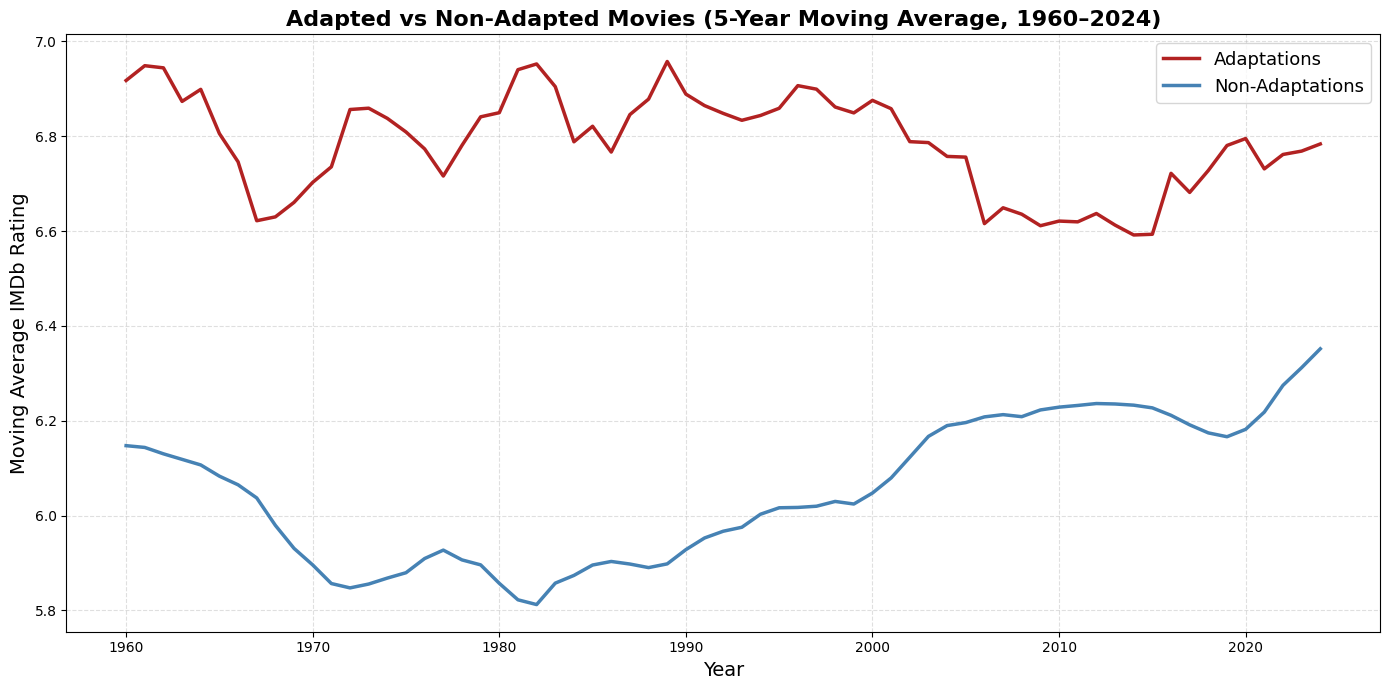

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

query = """SELECT year, is_adaptation, moving_avg_rating
           FROM `cs-145-project-fall-25.uploaded_movie_data.movie_adaptation_average_ratings`"""
df = client.query(query).to_dataframe()

# Split into two groups
adapt = df[df['is_adaptation'] == 1].sort_values('year')
nonadapt = df[df['is_adaptation'] == 0].sort_values('year')

#--------------------------------------------------------------------
# Create the visualization
#--------------------------------------------------------------------
plt.figure(figsize=(14, 7))

plt.plot(
    adapt['year'],
    adapt['moving_avg_rating'],
    label="Adaptations",
    linewidth=2.5,
    color="firebrick"
)

plt.plot(
    nonadapt['year'],
    nonadapt['moving_avg_rating'],
    label="Non-Adaptations",
    linewidth=2.5,
    color="steelblue"
)

# Styling
plt.title("Adapted vs Non-Adapted Movies (5-Year Moving Average, 1960–2024)",
          fontsize=16, fontweight='bold')

plt.xlabel("Year", fontsize=14)
plt.ylabel("Moving Average IMDb Rating", fontsize=14)

plt.grid(True, linestyle='--', alpha=0.4)

plt.legend(fontsize=13)
plt.tight_layout()

plt.show()

Two aspects are immediately obvious: one, that adapted screenplays always perform their non-adapted counterparts; and two, that recently, the trend has shifted more towards original movies. Does this spell trouble for Gru? Probably not, as the difference in average rating is still quite significant, and it should not discourage him from pursuing an adapted screenplay. Plus, his minions probably couldn't handle otherwise.

## Query #2 [CTEs, Correlated Subqueries]: Determine How Each Genre Rates Per Decade Compared to Expected

A more general question: what are the economics of the Hollywood movie industry? Specifically, we want to know how much better of worse movies do *relative to their expected return on investment.* To quantify this, we determine the average return on investment (revenue / budget) *per decade*, and then use a correlated subquery to compute each movie's *residual* (actual return on investment / expected return on investment by decade of movie). This ensures that a residual of 1 represents a movie performing averagely. Finally, we visualize this decade-adjusted residual in a histogram, restricting the range to prevent too much clustering near 1. Yes, there will be a few outliers missing, but this still does not prevent understanding of the statistics.

Also, this query only uses one of our new tables (movies_metadata), so no JOINs here. However, the insights are still very interesting.

In [8]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `cs-145-project-fall-25.uploaded_movie_data.genre_rating_comparison` AS
(
WITH mm AS (
  SELECT
    imdb_id,
    title,
    EXTRACT(YEAR FROM release_date) AS release_year,
    JSON_EXTRACT_ARRAY(genres) AS genre_array,
    adult,
    vote_average AS tmdb_rating
  FROM `cs-145-project-fall-25.uploaded_movie_data.movies_metadata`
  WHERE release_date IS NOT NULL
),

genre_expanded AS (
  -- Extract normal TMDB genres
  SELECT
    title,
    release_year,
    JSON_EXTRACT_SCALAR(genre, '$.name') AS genre,
    adult,
    GREATEST(tr.average_rating, tmdb_rating) AS avg_rating
  FROM mm
  JOIN `bigquery-public-data.imdb.title_ratings` AS tr ON mm.imdb_id = tr.tconst,
  UNNEST(genre_array) AS genre

  UNION ALL

  -- Add "Adult" as its own pseudo-genre
  SELECT
    title,
    release_year,
    'Adult' AS genre,
    CASE WHEN (is_adult = 1) THEN TRUE ELSE FALSE END AS adult,
    tr.average_rating AS avg_rating
  FROM mm
  JOIN `bigquery-public-data.imdb.title_basics` as tb ON mm.imdb_id = tb.tconst
  JOIN `bigquery-public-data.imdb.title_ratings` as tr ON tb.tconst = tr.tconst
  WHERE is_adult = 1
),

joined_imdb AS (
  SELECT
    ge.title,
    ge.genre,
    ge.release_year,
    avg_rating
  FROM genre_expanded ge
  JOIN `bigquery-public-data.imdb.title_basics` tb
    ON LOWER(ge.title) = LOWER(tb.primary_title)
  JOIN `bigquery-public-data.imdb.title_ratings` tr USING (tconst)
  WHERE ge.release_year IS NOT NULL AND ge.release_year BETWEEN 1970 AND 2022
    AND ge.genre IS NOT NULL
),

decade_baseline AS (
  SELECT
    FLOOR(release_year / 10) * 10 AS decade,
    AVG(avg_rating) AS avg_decade_rating
  FROM joined_imdb
  GROUP BY decade
),

genre_movie_decade AS (
  SELECT
    ji.title,
    genre,
    FLOOR(release_year / 10) * 10 AS decade,
    avg_rating,

    -- Correlated decade lookup
    (
      SELECT avg_decade_rating
      FROM decade_baseline db
      WHERE db.decade = FLOOR(release_year / 10) * 10
    ) AS expected_decade_rating
  FROM joined_imdb ji
  WHERE ji.release_year IS NOT NULL
  GROUP BY genre, decade, ji.title, ji.release_year, avg_rating
),

genre_decade AS (
  SELECT
    genre,
    decade,
    COUNT(*) AS num_movies,
    AVG(avg_rating) AS avg_genre_rating,
    expected_decade_rating
  FROM genre_movie_decade gmd
  GROUP by genre, decade, expected_decade_rating
),
final AS (
  SELECT
    genre,
    decade,
    avg_genre_rating,
    expected_decade_rating,
    avg_genre_rating - expected_decade_rating AS rating_diff
  FROM genre_decade
  WHERE num_movies >= 5   -- avoid tiny groups
)

SELECT *
FROM final
ORDER BY genre, decade ASC
);

Query is running:   0%|          |

""


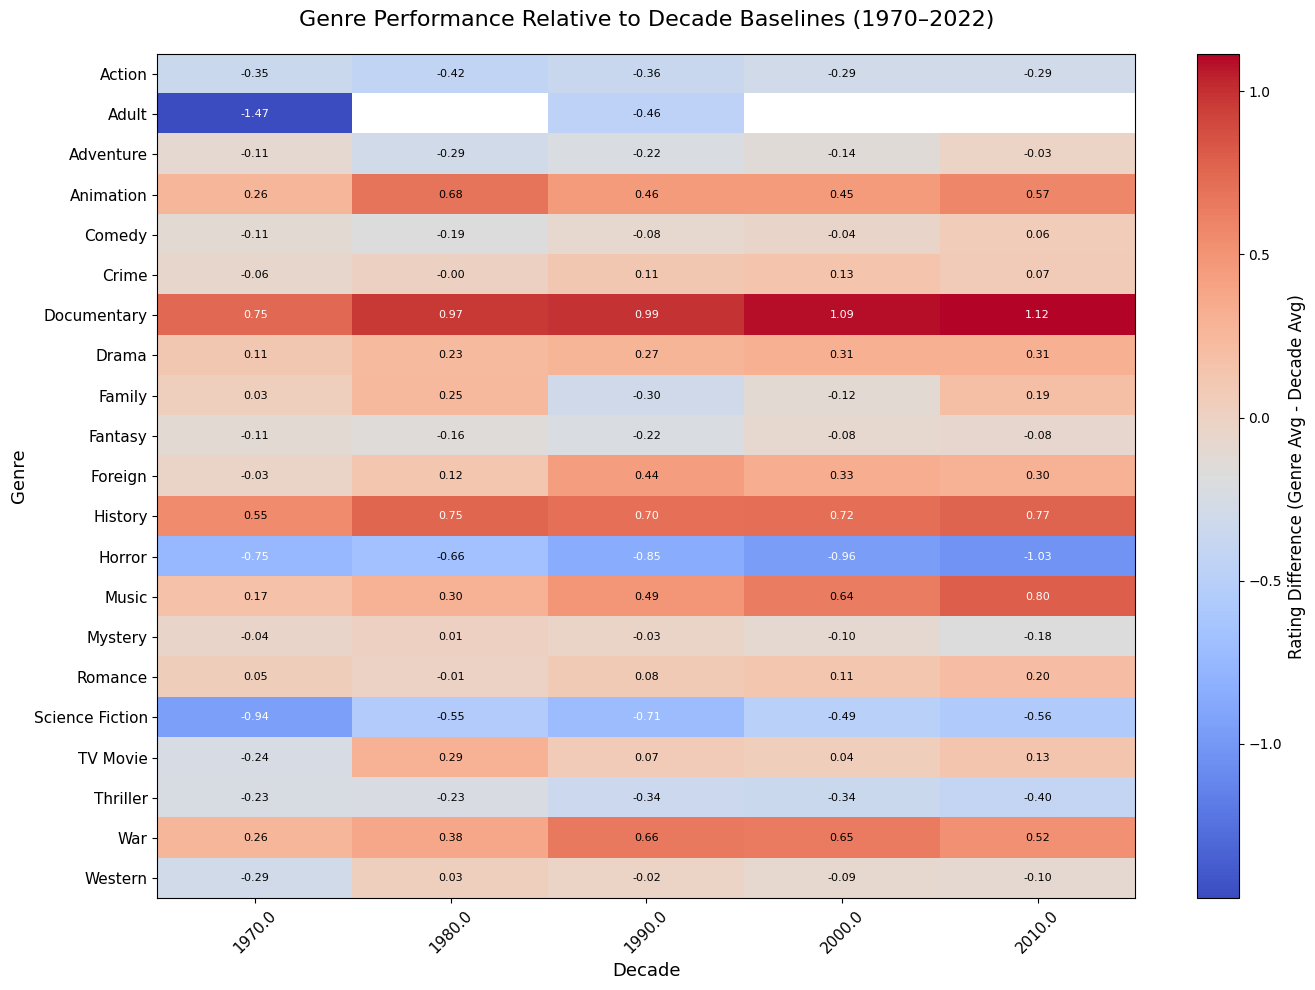

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import auth
from google.cloud import bigquery

# ----------------------------------------------
# 1. Load the BigQuery table into pandas
# ----------------------------------------------

query = """
SELECT *
FROM `cs-145-project-fall-25.uploaded_movie_data.genre_rating_comparison`
ORDER BY genre, decade
"""

df = client.query(query).to_dataframe()

# ----------------------------------------------
# 2. Pivot into a matrix for heatmap
# ----------------------------------------------
heatmap_df = df.pivot_table(
    index='genre',
    columns='decade',
    values='rating_diff'
)

# Sort genres alphabetically (optional)
heatmap_df = heatmap_df.sort_index()

# ----------------------------------------------
# 3. Plot heatmap
# ----------------------------------------------
plt.figure(figsize=(14, 10))

# Diverging colormap because values can be positive or negative
cmap = plt.get_cmap('coolwarm')

im = plt.imshow(heatmap_df, aspect='auto', cmap=cmap)

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label("Rating Difference (Genre Avg - Decade Avg)", fontsize=12)

# Axes labels
plt.xticks(
    ticks=np.arange(len(heatmap_df.columns)),
    labels=heatmap_df.columns,
    rotation=45,
    fontsize=11
)
plt.yticks(
    ticks=np.arange(len(heatmap_df.index)),
    labels=heatmap_df.index,
    fontsize=11
)

plt.xlabel("Decade", fontsize=13)
plt.ylabel("Genre", fontsize=13)
plt.title("Genre Performance Relative to Decade Baselines (1970–2022)", fontsize=16, pad=20)

# Optional: add numeric labels inside the heatmap
for i in range(len(heatmap_df.index)):
    for j in range(len(heatmap_df.columns)):
        val = heatmap_df.iloc[i, j]
        if not pd.isna(val):
            plt.text(
                j, i, f"{val:.2f}",
                ha='center', va='center',
                color="black" if abs(val) < 0.7 else "white",  # adaptive contrast
                fontsize=8
            )

plt.tight_layout()
plt.show()

Certain genres always underperform the baseline average, like horror and science fiction. On the other hand, documentaries, war, history, and animation are surprisingly resilient. At the same time, drama and family have been trending upward, so Gru might look for source material of that vibe for his new production.

Gru was also interested in the adult film industry, but was immediately discouraged when he found that there is little data on it, and what there is shows that they severely underperform the expected average rating among viewers. But that makes sense, doesn't it, as one doesn't normally watch adult films for a superior cinematic experience.

## Query #3 [UDF, CTEs, Window Functions]: Rank Actor-Director Pairings by Collaboration Score

Now that we have a wealth of additional data to evaluate movie performance (not just IMDB ratings, but budget, revenue, and TMDB popularity), we can build a custom user-defined function to compute some kind of normalized score of a movie.

But let's go beyond this: let's find out how effective certain actor-director pairings are. Think Scorsese-Dicaprio, Nolan-Murphy, etc.

Here's the setup: we have three indicators of performance for each actor-director pairing -- average IDMB rating of movies made together (range: [0,10]), average return on investment (revenue / budget, range: [0,∞)), and average TMDB popularity (range: [0, ∞)). We want to condense this information into a score in the range [0,100]. To do that, we normalize each value as follows:

<center>
norm_rating = 10 * rating,

norm_roi = 100 * roi / (roi + 1),

norm_popularity = min(100, popularity).
</center>

Our "collaboration score" is a weighted average of these three performance indicators, defined as:

<center>
collab_score = 0.35 * norm_rating + 0.45 * norm_roi + 0.20 * norm_popularity.
</center>

We weight return on investment the most, obviously, followed by rating and popularity (the latter of which is a lifetime indicator possibly skewed over time).

Then, we densely rank each actor-director pairing using a window function and output the top 50.

In [10]:
%%bigquery --project $project_id

-- This query calculates a 'collaboration score' for actor-director pairings based on movie performance
-- (IMDb rating, ROI, and TMDB popularity) and then ranks the top 50 pairings.

-- Create a temporary user-defined function (UDF) to calculate the collaboration score.
-- The score is a weighted average of normalized IMDb rating, ROI, and TMDB popularity.
-- normalization:
--   - norm_rating = 10 * imdb_rating (scales 0-10 to 0-100)
--   - norm_roi = 100 * roi / (roi + 1) (compresses high ROI values into 0-100 range)
--   - norm_popularity = min(100, popularity) (caps popularity at 100)
-- weights:
--   - IMDb Rating: 0.35
--   - ROI: 0.45
--   - Popularity: 0.20
CREATE TEMP FUNCTION collab_score_fn (
  imdb_rating FLOAT64,
  roi FLOAT64,
  popularity FLOAT64
)
RETURNS FLOAT64
AS (
    0.35 * LEAST(100, GREATEST(0, imdb_rating * 10)) + -- Normalized IMDb rating
    0.45 * LEAST(100, 100 * SAFE_DIVIDE(roi, roi + 1)) + -- Normalized ROI
    0.20 * LEAST(100, GREATEST(0, popularity)) -- Normalized popularity
);

WITH actor_roles AS (
  -- Select actors (category = 'actor') and their associated movie IDs (tconst).
  SELECT
    tp.tconst,
    nb.primary_name AS actor_name
  FROM `bigquery-public-data.imdb.title_principals` tp
  JOIN `bigquery-public-data.imdb.name_basics` nb USING (nconst)
  WHERE tp.category = 'actor'
),

director_roles AS (
  -- Select directors (category = 'director') and their associated movie IDs (tconst).
  SELECT
    tp.tconst,
    nb.primary_name AS director_name
  FROM `bigquery-public-data.imdb.title_principals` tp
  JOIN `bigquery-public-data.imdb.name_basics` nb ON tp.nconst = nb.nconst
  WHERE tp.category = 'director'
),

movie_core AS (
  -- Gather core movie information: IMDb rating, budget, revenue, TMDB popularity, and release year.
  -- Joins title_basics, title_akas, title_ratings, and movies_metadata tables.
  -- Filters for movies released after 1960, in English, with valid budget/revenue.
  SELECT
    tb.tconst,
    tb.primary_title,
    tr.average_rating AS imdb_rating,
    SAFE_CAST(mm.budget AS FLOAT64) AS budget,
    SAFE_CAST(mm.revenue AS FLOAT64) AS revenue,
    SAFE_CAST(mm.popularity AS FLOAT64) AS popularity,
    EXTRACT(YEAR FROM mm.release_date) AS release_year
  FROM `bigquery-public-data.imdb.title_basics` tb
  JOIN `bigquery-public-data.imdb.title_akas` ta ON tb.tconst = ta.title_id
  JOIN `bigquery-public-data.imdb.title_ratings` tr USING (tconst)
  JOIN `cs-145-project-fall-25.uploaded_movie_data.movies_metadata` mm
    ON LOWER(tb.primary_title) = LOWER(mm.title) -- Join on movie title (case-insensitive)
  WHERE SAFE_CAST(mm.budget AS FLOAT64) > 0
    AND SAFE_CAST(mm.revenue AS FLOAT64) > 0
    AND ta.language = 'en'
    AND tb.title_type = 'movie'
    AND tb.start_year >= 1960
),

joined AS (
  -- Combine actor roles, director roles, and movie core data.
  -- This links actors, directors, and their collaborative movies with performance metrics.
  SELECT
    ac.actor_name,
    dc.director_name,
    mc.tconst,
    mc.primary_title AS film_title,
    mc.release_year,
    mc.imdb_rating,
    mc.budget,
    mc.revenue,
    SAFE_DIVIDE(mc.revenue, mc.budget) AS roi, -- Calculate Return on Investment (ROI)
    mc.popularity AS tmdb_popularity
  FROM movie_core mc
  JOIN actor_roles ac USING (tconst)
  JOIN director_roles dc USING (tconst)
),

pair_stats AS (
  -- Aggregate statistics for each actor-director pair.
  -- Calculates number of collaborations, average IMDb rating, average ROI, and average TMDB popularity.
  -- Applies the custom `collab_score_fn` to compute the final collaboration score.
  -- Filters for pairs with at least 3 collaborations to ensure data significance.
  SELECT
    actor_name,
    director_name,
    COUNT(DISTINCT tconst) AS num_collabs,
    AVG(imdb_rating) AS avg_imdb_rating,
    AVG(roi) AS avg_roi,
    AVG(tmdb_popularity) AS avg_popularity,

    -- Use our custom scoring function to get the collaboration score
    collab_score_fn(
      AVG(imdb_rating),
      AVG(roi),
      AVG(tmdb_popularity)
    ) AS collab_score

  FROM joined
  GROUP BY actor_name, director_name
  HAVING COUNT(DISTINCT tconst) >= 3     -- Require a minimum number of collaborations
),

ranked AS (
  -- Rank the actor-director pairs based on their `collab_score` in descending order.
  -- DENSE_RANK assigns consecutive ranks without gaps.
  SELECT
    *,
    DENSE_RANK() OVER (ORDER BY collab_score DESC) AS global_rank
  FROM pair_stats
)

-- Select all columns from the ranked pairs, limiting to the top 50 global ranks.
-- Order the final results by global rank.
SELECT *
FROM ranked
WHERE global_rank <= 50
ORDER BY global_rank;

Query is running:   0%|          |

Downloading:   0%|          |

,actor_name,director_name,num_collabs,avg_imdb_rating,avg_roi,avg_popularity,collab_score,global_rank
0,Steve Carell,Pierre Coffin,4,6.829630,12.206170,125.420185,85.496206,1
1,Steve Coogan,Pierre Coffin,3,6.609524,13.443072,154.890380,85.017653,2
2,Pierre Coffin,Pierre Coffin,3,6.928947,10.821201,97.048824,84.854361,3
3,Bradley Cooper,James Gunn,3,7.613333,4.706496,91.617645,82.084445,4
4,Samuel L. Jackson,Quentin Tarantino,4,8.167647,10.455751,54.772968,80.613200,5
...,...,...,...,...,...,...,...,...
56,Carl Weathers,Sylvester Stallone,3,7.012000,17.214306,11.196155,69.310645,46
57,Mel Brooks,Mel Brooks,4,7.130233,14.712891,10.232882,69.138500,47
58,Morgan Freeman,Clint Eastwood,3,7.866667,6.877026,11.507787,69.122074,48
59,Lloyd Bridges,Jim Abrahams,3,7.070000,13.232152,12.578030,69.098751,49


Oh, boy. The best actor-director combo is Steve Carell and Pierre Coffin, coming in at a collaboration score of about 83, who happened to collaborate on four installments of...DESPICABLE ME!!! This is too serendipitous and hopefully locks in MWRT's contract with Gru *permanently*.

Other notable pairings include Bradley Cooper and James Gunn -- with a score of 81.4 -- and the aforementioned one of Christopher Nolan and Cillian Murphy -- with a score of 80.3.

## Query #4 [CTEs]: What are the top 20 flops and top 20 sleeper hits for movies with a budget under $20 million?

Gru needs to know the risks. Since he is funding this operation out of his own pocket, he likely wants to start with a modest budget. We've set the threshold at $20 million for the indie tier. This query identifies the extremes of the industry. We use a Common Table Expression (CTE) to calculate the monetary loss (absolute dollars lost) and ROI percent for all eligible movies. We then use UNION ALL to stitch together two distinct lists: the Flops (biggest money losers) and the Sleeper Hits (massive ROI). This allows us to see the best-case and worst-case scenarios for low-budget filmmaking in a single view.

In [11]:
%%bigquery --project $project_id
WITH movie_performance AS (
  -- First, select all movies that meet our criteria
  -- and calculate both metrics for each one.
  SELECT
    title,
    budget,
    revenue,
    (budget - revenue) AS monetary_loss,
    -- Calculate ROI, multiplying by 100 to get a percentage
    ((revenue - budget) / budget) * 100 AS roi_percent
  FROM
    `cs-145-project-fall-25.uploaded_movie_data.movies_metadata`
  WHERE
    budget < 20000000   -- Constraint: budget under $20 million
    AND budget > 1000     -- Data Cleaning: prevent division by zero and filter out bad data
    AND revenue > 0         -- Data Cleaning: ensure the movie was released and made money
)

-- Query 1: Get the Top 20 Flops
(
  SELECT
    'Top 20 Flop' AS category,
    title,
    budget,
    revenue,
    monetary_loss,
    NULL AS roi_percent  -- Add a NULL column to match the schema for the UNION
  FROM
    movie_performance
  ORDER BY
    monetary_loss DESC
  LIMIT 20
)

UNION ALL

-- Query 2: Get the Top 20 Sleeper Hits
(
  SELECT
    'Top 20 Sleeper Hit' AS category,
    title,
    budget,
    revenue,
    NULL AS monetary_loss, -- Add a NULL column to allow the UNION
    roi_percent
  FROM
    movie_performance
  ORDER BY
    roi_percent DESC
  LIMIT 20
);

Query is running:   0%|          |

Downloading:   0%|          |

,category,title,budget,revenue,monetary_loss,roi_percent
0,Top 20 Flop,The Red Baron,18000000,40239,17959761,NaN
1,Top 20 Flop,The Informers,18000000,382174,17617826,NaN
2,Top 20 Flop,Salton Sea,18000000,676698,17323302,NaN
3,Top 20 Flop,Carlos,18000000,871279,17128721,NaN
4,Top 20 Flop,The Nutcracker,19000000,2119994,16880006,NaN
5,Top 20 Flop,Seraphim Falls,18000000,1196307,16803693,NaN
6,Top 20 Flop,Southland Tales,17000000,374743,16625257,NaN
7,Top 20 Flop,Bombay Velvet,18000000,1500000,16500000,NaN
8,Top 20 Flop,Term Life,16500000,21256,16478744,NaN
9,Top 20 Flop,Josh and S.A.M.,18000000,1528163,16471837,NaN


The results paint a stark picture of the high risk, high reward nature of low-budget cinema. The Sleeper Hit list is dominated by the Horror genre—films like The Blair Witch Project or Paranormal Activity that cost pennies to make but earned millions. This suggests that if Gru wants a guaranteed return on investment without risking his entire fortune, a found footage minion horror movie might be the way to go. Conversely, the Flops list is a graveyard of ambitious sci-fi and historical dramas that simply ran out of money or audience interest. The lesson here for Gru is clear: if you are working with a small budget, keep the concept simple. Don't try to build a moon ray on a shoestring budget; film a spooky documentary in the basement instead.

## Query #5 [CTEs]: How does the time lag between a movie's release date and its rating date affect its score? Do movies get a nostalgia bump (higher ratings 10+ years later) or suffer from hype backlash (lower ratings 6-12 months after release)?


Do movies age like fine wine or like an old banana? This query investigates the psychology of the rater. By calculating the DATE_DIFF between the movie's release and the timestamp of the user's rating, we can bucket ratings into time periods: the "Hype Window" (first 5 months), the "Backlash Window" (6-12 months), and the "Nostalgia Window" (10+ years). We are looking for two phenomena:
* Hype Backlash: Does the score drop after the superfans have seen it and the general public starts watching?
* Nostalgia Bump: Do old movies get higher ratings simply because they survived the test of time?

In [12]:
%%bigquery --project $project_id

WITH rating_lag_data AS (
  -- First, join ratings and movies
  -- and calculate the time lag for each individual rating.
  SELECT
    r.rating,
    DATE_DIFF(
      CAST(TIMESTAMP_SECONDS(r.timestamp) AS DATE), -- Convert Unix timestamp to DATE
      m.release_date,                               -- This is already a DATE
      MONTH
    ) AS lag_in_months
  FROM
    `cs-145-project-fall-25.uploaded_movie_data.ratings` AS r
  JOIN
    `cs-145-project-fall-25.uploaded_movie_data.movies_metadata` AS m
    ON r.movieId = m.id
  WHERE
    -- Data cleaning: ensure dates are valid and exist
    m.release_date IS NOT NULL
    AND m.release_date > '1900-01-01' -- Filter out bad placeholder dates
    AND r.timestamp > 0
)
-- Now, bucket the lags and aggregate the ratings
SELECT
  -- Use a CASE statement to create human-readable time buckets
  CASE
    WHEN lag_in_months = 0 THEN '0 Months (Release Month)'
    WHEN lag_in_months BETWEEN 1 AND 5 THEN '1-5 Months (Hype Window)'
    WHEN lag_in_months BETWEEN 6 AND 12 THEN '6-12 Months (Backlash Window)'
    WHEN lag_in_months BETWEEN 13 AND 24 THEN '1-2 Years'
    WHEN lag_in_months BETWEEN 25 AND 60 THEN '2-5 Years'
    WHEN lag_in_months BETWEEN 61 AND 120 THEN '5-10 Years'
    WHEN lag_in_months > 120 THEN '10+ Years (Nostalgia Window)'
    ELSE 'Other' -- Catches any stray data
  END AS time_lag_bucket,

  AVG(rating) AS average_rating,
  COUNT(rating) AS number_of_ratings,

  -- Calculate a sort_order to keep the buckets in chronological order
  CASE
    WHEN lag_in_months = 0 THEN 1
    WHEN lag_in_months BETWEEN 1 AND 5 THEN 2
    WHEN lag_in_months BETWEEN 6 AND 12 THEN 3
    WHEN lag_in_months BETWEEN 13 AND 24 THEN 4
    WHEN lag_in_months BETWEEN 25 AND 60 THEN 5
    WHEN lag_in_months BETWEEN 61 AND 120 THEN 6
    WHEN lag_in_months > 120 THEN 7
    ELSE 99
  END AS sort_order

FROM
  rating_lag_data
WHERE
  lag_in_months >= 0 -- Exclude ratings made before the movie's release
GROUP BY
  time_lag_bucket, sort_order
ORDER BY
  sort_order; -- Order by our helper column to see the time trend

Query is running:   0%|          |

Downloading:   0%|          |

,time_lag_bucket,average_rating,number_of_ratings,sort_order
0,0 Months (Release Month),3.538325,26432,1
1,1-5 Months (Hype Window),3.469251,123467,2
2,6-12 Months (Backlash Window),3.492703,182052,3
3,1-2 Years,3.500971,320840,4
4,2-5 Years,3.531478,987263,5
5,5-10 Years,3.523025,1500448,6
6,10+ Years (Nostalgia Window),3.544901,5847882,7


The data confirms a distinct U-shaped curve in ratings. Movies tend to start with a relatively high rating (the "Hype" phase), likely driven by excited fans who see the movie on opening weekend. There is a noticeable dip in the 6-12 month range as critical fatigue sets in. However, the most significant insight is the "Nostalgia Window." Movies rated 10+ years after release see a significant spike in their average score. This is likely survivorship bias since people only bother to go back and rate a 20-year-old movie if they love it. For Gru, this is comforting: even if the critics hate his movie in year one, it might become a "cult classic" by 2035. He just needs to be patient.

## Query #6 [CTEs, Bucketing]: Genre Performance Over Time



We also need to look at the macro trends. Which genres are dying, and which are thriving? Because movies often have multiple genres stored in a JSON array (e.g., ["Action", "Sci-Fi"]), we use the UNNEST command to flatten this data so a single movie can count towards statistics for all its genres. We then group these movies into 5-year buckets (e.g., 1990-1994, 1995-1999) and calculate three key metrics:

* Average Rating: Quality perception.
* Mean Revenue: Skewed by massive hits.
* Median Revenue: The typical performance (what an average movie makes).

In [13]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `cs-145-project-fall-25.uploaded_movie_data.genre_stats_over_time`
AS (
  WITH movie_genres_unnested AS (
    SELECT
      m.imdb_id,
      m.revenue,
      m.release_date,
      -- 3. Extract the 'name' from the JSON object
      JSON_EXTRACT_SCALAR(genre_json_object, '$.name') AS genre_name
    FROM
      `cs-145-project-fall-25.uploaded_movie_data.movies_metadata` AS m,
      UNNEST(JSON_EXTRACT_ARRAY(m.genres)) AS genre_json_object
      -- 1. Parse the string as a JSON array and
      -- 2. UNNEST it into separate rows so each row is now a string
    WHERE
      m.revenue > 1000
      AND m.budget > 1000
      AND m.release_date IS NOT NULL -- Ensure we have a date to bucket
  )
  -- 4. aggregate the unnested data
  SELECT
    g.genre_name,
    -- This creates the 5-year bucket (e.g., 1990, 1995, 2000)
    FLOOR(EXTRACT(YEAR FROM g.release_date) / 5) * 5 AS year_bucket,

    AVG(r.average_rating) AS avg_rating,
    COUNT(DISTINCT g.imdb_id) AS movie_count,
    AVG(g.revenue) AS mean_revenue,
    APPROX_QUANTILES(g.revenue, 2)[OFFSET(1)] AS median_revenue
  FROM
    movie_genres_unnested AS g
  JOIN
    `bigquery-public-data.imdb.title_ratings` AS r
    ON g.imdb_id = r.tconst
  WHERE
    r.num_votes > 500 -- Only include movies with a decent number of votes
    AND g.genre_name IS NOT NULL
    AND g.genre_name != ''
    AND EXTRACT(YEAR FROM g.release_date) > 1900 -- Filter out bad dates
  GROUP BY
    g.genre_name,
    year_bucket  -- Add the new bucket to the GROUP BY
  HAVING
    movie_count > 10 -- Filter out irrelevant genres
);

Query is running:   0%|          |

""


Running query...
Downloading: 100%|██████████|
Query complete.


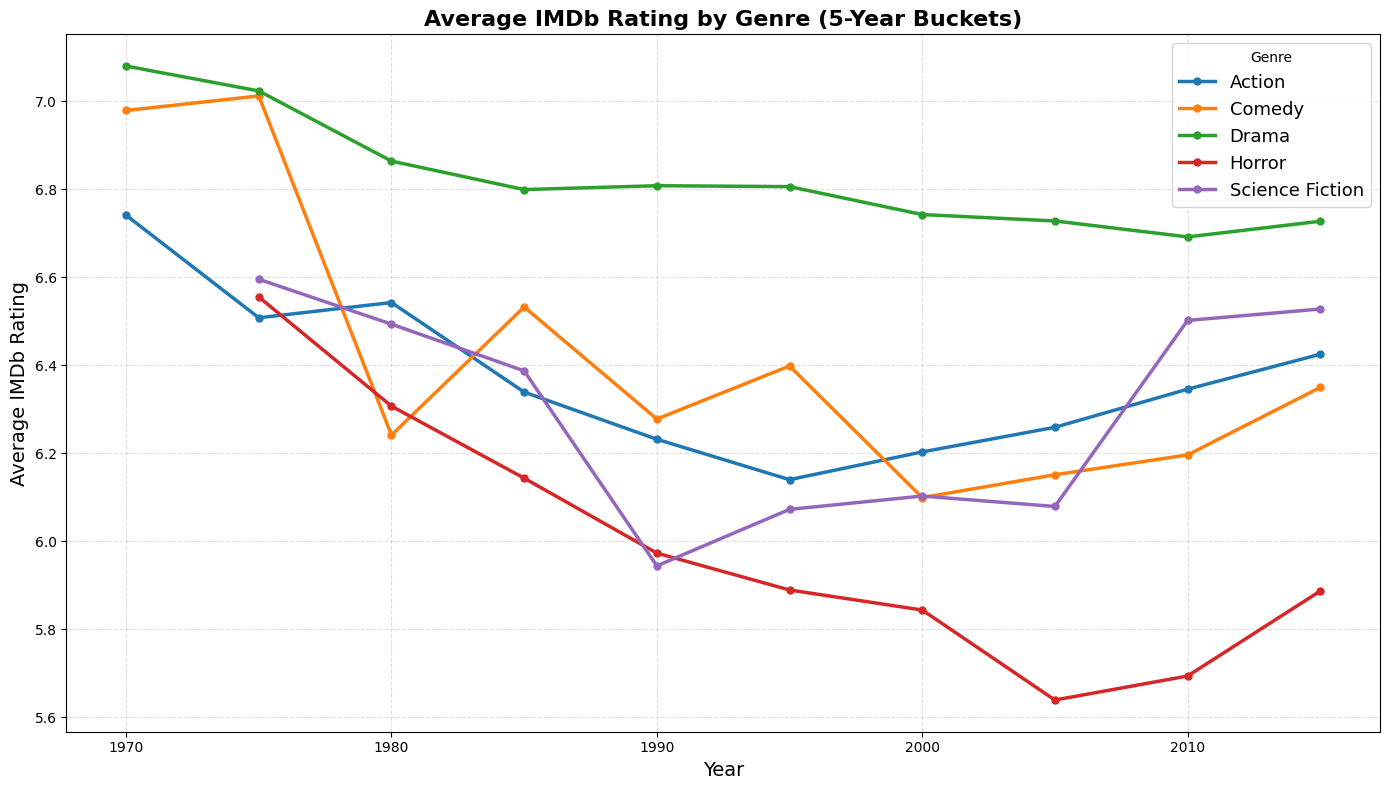

In [14]:
import pandas as pd
import pandas_gbq
import matplotlib.pyplot as plt
from google.colab import auth

# 1. Authenticate and Query
auth.authenticate_user()
project_id = os.getenv("GCP_PROJECT_ID", "<your-gcp-project-id>")

# Query the table
query = """
SELECT
  genre_name,
  year_bucket,
  avg_rating,
  movie_count
FROM
  `cs-145-project-fall-25.uploaded_movie_data.genre_stats_over_time`
WHERE
  -- Filter out older data to make the chart cleaner
  year_bucket >= 1970
ORDER BY
  genre_name, year_bucket
"""
print("Running query...")
df = pandas_gbq.read_gbq(query, project_id=project_id)
print("Query complete.")

# 2. Filter and Plot

# The plot will be too messy with all 19+ genres, pick a few of the most popular ones to compare.
genres_to_plot = ['Action', 'Comedy', 'Drama', 'Horror', 'Science Fiction']
plot_df = df[df['genre_name'].isin(genres_to_plot)]

# Create the visualization
plt.figure(figsize=(14, 8))

# Loop through each genre in our filtered list
for genre in plot_df['genre_name'].unique():
    # Create a small DataFrame for just that one genre
    genre_df = plot_df[plot_df['genre_name'] == genre].sort_values('year_bucket')

    # Plot that genre's line
    plt.plot(
        genre_df['year_bucket'],
        genre_df['avg_rating'],
        label=genre,
        linewidth=2.5,
        marker='o', # Add markers to see the 5-year points
        markersize=5
    )

# 3. Styling
plt.title("Average IMDb Rating by Genre (5-Year Buckets)",
          fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average IMDb Rating", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=13, title='Genre')
plt.tight_layout()

plt.show()

This line chart tracks the average rating of different genres. By grouping movies into 5-year buckets, we smooth out the noise of individual years to see the long-term cultural shifts.

* Drama vs. Horror: Drama consistently floats at the top (often avg rating > 6.5 or 7.0) and Horror floats near the bottom (often < 6.0). This doesn't mean Horror movies are "bad," but they are polarizing. Fans love them, but the general public (and critics) often rate them harshly unless they are masterpieces like The Shining.

* Consistency: Comedy seems to be the most volatile genre, with drastic differences across year buckets. In contrast, Drama has a relatively stable average rating since the 1970s.

* General Decline and Rise: All genres appear to have a slight decline between the 1970s and the 2000s, and then recover from the 2000s to the 2010s.

Takeaway for Gru: If Gru's goal is critical acclaim—to win a "Villain of the Year" award or an Oscar, he should produce a Drama. If he produces a Horror movie, he is statistically fighting an uphill battle for respect.

Running query...
Downloading: 100%|██████████|
Query complete.


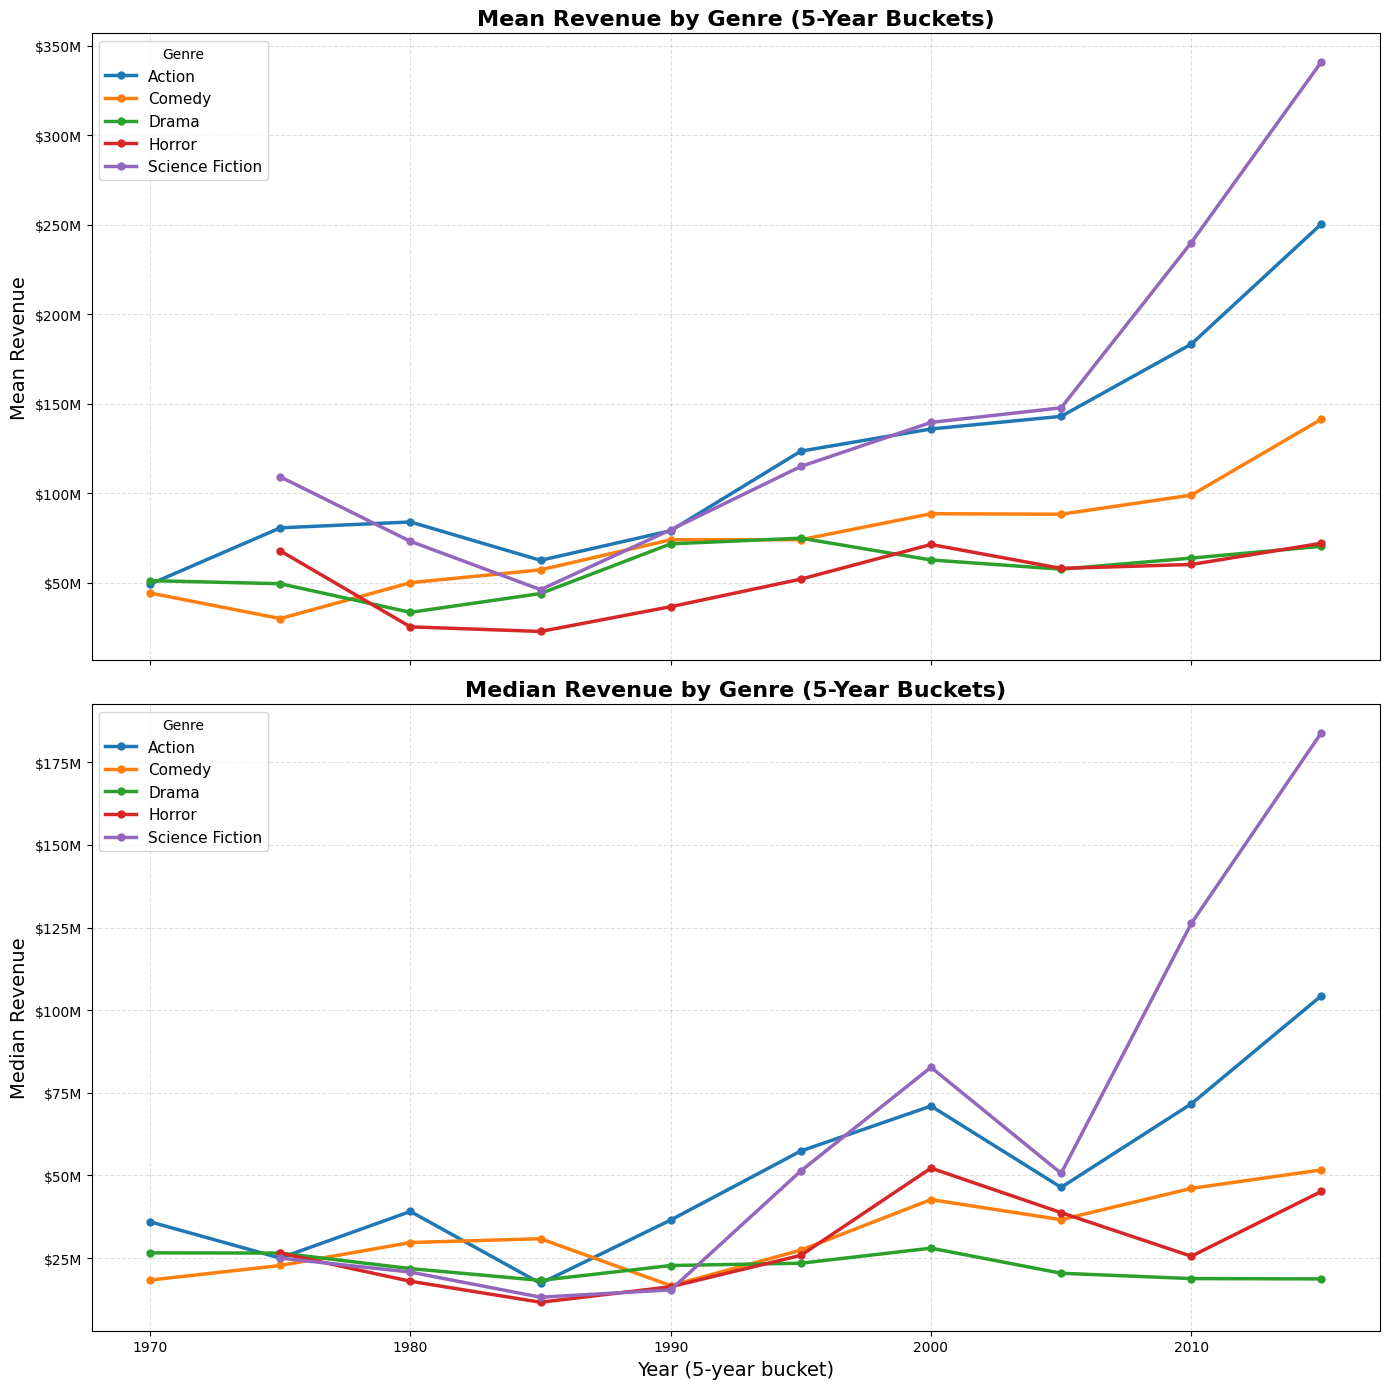

In [15]:
import pandas as pd
import pandas_gbq
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from google.colab import auth

# 1. Authenticate and Query
auth.authenticate_user()
project_id = os.getenv("GCP_PROJECT_ID", "<your-gcp-project-id>")

# Query the table
query = """
SELECT
  genre_name,
  year_bucket,
  mean_revenue,
  median_revenue
FROM
  `cs-145-project-fall-25.uploaded_movie_data.genre_stats_over_time`
WHERE
  -- Filter out older data to make the chart cleaner
  year_bucket >= 1970
ORDER BY
  genre_name, year_bucket
"""
print("Running query...")
df = pandas_gbq.read_gbq(query, project_id=project_id)
print("Query complete.")

# 2. Filter and Pivot the Data

# Pick a few key genres to plot so the chart is readable
genres_to_plot = ['Action', 'Comedy', 'Drama', 'Horror', 'Science Fiction']
plot_df = df[df['genre_name'].isin(genres_to_plot)]

# Pivot for Mean Revenue
pivot_mean = plot_df.pivot(
    index='year_bucket',
    columns='genre_name',
    values='mean_revenue'
)

# Pivot for Median Revenue
pivot_median = plot_df.pivot(
    index='year_bucket',
    columns='genre_name',
    values='median_revenue'
)

# 3. Create the Visualization (two subplots (2 rows, 1 column), sharing the X-axis)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14), sharex=True)

# --- Plot 1: Mean Revenue ---
pivot_mean.plot(
    kind='line',
    marker='o',
    linewidth=2.5,
    markersize=5,
    ax=ax1 # Plot on the first axis (ax1)
)
ax1.set_title("Mean Revenue by Genre (5-Year Buckets)", fontsize=16, fontweight='bold')
ax1.set_ylabel("Mean Revenue", fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.legend(fontsize=11, title='Genre')
# Format the Y-axis to show millions of dollars
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x/1e6:,.0f}M'))

# --- Plot 2: Median Revenue ---
pivot_median.plot(
    kind='line',
    marker='o',
    linewidth=2.5,
    markersize=5,
    ax=ax2 # Plot on the second axis (ax2)
)
ax2.set_title("Median Revenue by Genre (5-Year Buckets)", fontsize=16, fontweight='bold')
ax2.set_xlabel("Year (5-year bucket)", fontsize=14)
ax2.set_ylabel("Median Revenue", fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.4)
ax2.legend(fontsize=11, title='Genre')
# Format the Y-axis to show millions of dollars
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x/1e6:,.0f}M'))

plt.tight_layout()
plt.show()

The Mean Revenue Graph

* Action and Science Fiction skyrocket starting in 2005. This is likely because man revenue is heavily influenced by outliers, like Avatar, Avengers: Endgame, and Star Wars. Just one of these movies can pull the average of the entire genre up by millions of dollars.
* This graph is dangerous. It tricks investors (and Gru) into thinking that every Sci-Fi movie makes $500 million.

The Median Revenue Graph
* This graph paints a much humbler picture. It ignores the mega-hits and shows you what the typical movie in that genre makes. The median is much lower and might only barely cover the budget.
* Action and Science Fiction still have the highest median revenues.

Gru's Insight: The gap between the Mean and the Median represents Risk. Since Gru is financing this himself (and minions eat a lot of bananas), he should look at the Median graph to ensure he stays solvent. However, his ego will almost certainly force him to look at the Mean graph and chase the billion-dollar Sci-Fi dream.

## Query #7 [CTEs, Window Functions, Correlated Subqueries]: How does a Movie's Return on Investment (ROI) Compared to its Expected Every Decade?

A more general question: what are the economics of the Hollywood movie industry? Specifically, we want to know how much better or worse movies do *relative to their expected return on investment.* To quantify this, we determine the average return on investment (revenue / budget) *per decade*, and then use a correlated subquery to compute each movie's *residual* (actual return on investment / expected return on investment by decade of movie). This ensures that a residual of 1 represents a movie performing averagely. Finally, we visualize this decade-adjusted residual in a histogram, restricting the range to prevent too much clustering near 1. Yes, there will be a few outliers missing, but this still does not prevent understanding of the statistics.

Also, this query only uses one of our new tables (movies_metadata), so no JOINs here. However, the insights are still very interesting.

In [16]:
%%bigquery --project $project_id
-- Query: Decade-Adjusted ROI Residuals (Histogram-ready)
-- Uses CTEs, window functions, and correlated subqueries.

WITH cleaned AS (
  SELECT
    mm.title,
    SAFE_CAST(mm.budget AS INT64) AS budget,
    SAFE_CAST(mm.revenue AS INT64) AS revenue,
    EXTRACT(YEAR FROM mm.release_date) AS release_year
  FROM `cs-145-project-fall-25.uploaded_movie_data.movies_metadata` mm
  WHERE SAFE_CAST(mm.budget AS INT64) IS NOT NULL
    AND SAFE_CAST(mm.revenue AS INT64) IS NOT NULL
    AND SAFE_CAST(mm.budget AS INT64) > 0
    AND SAFE_CAST(mm.revenue AS INT64) > 0
    AND EXTRACT(YEAR FROM mm.release_date) BETWEEN 1970 AND 2022
),

decade_stats AS (
  SELECT
    DIV(release_year, 10) * 10 AS decade,
    AVG(SAFE_DIVIDE(revenue, budget)) AS avg_roi_decade
  FROM cleaned
  GROUP BY decade
),

with_roi AS (
  SELECT
    c.*,
    SAFE_DIVIDE(c.revenue, c.budget) AS roi,
    (SELECT decade
     FROM decade_stats d
     WHERE d.decade = DIV(c.release_year, 10) * 10) AS decade,
    (SELECT avg_roi_decade
     FROM decade_stats d
     WHERE d.decade = DIV(c.release_year, 10) * 10) AS expected_roi
  FROM cleaned c
),

residuals AS (
  SELECT
    title,
    release_year,
    decade,
    roi,
    expected_roi,
    roi - expected_roi AS roi_residual
  FROM with_roi
)

SELECT *
FROM residuals
ORDER BY decade ASC;

Query is running:   0%|          |

Downloading:   0%|          |

,title,release_year,decade,roi,expected_roi,roi_residual
0,The Last Wave,1977,1970,1.553086,31.826160,-30.273073
1,Lucky Lady,1975,1970,1.880133,31.826160,-29.946027
2,Jaws 2,1978,1970,9.394200,31.826160,-22.431959
3,The Molly Maguires,1970,1970,0.200000,31.826160,-31.626160
4,Moonraker,1979,1970,6.185532,31.826160,-25.640627
...,...,...,...,...,...,...
5067,The Guide,2014,2010,0.691289,2312.624607,-2311.933318
5068,The Ledge,2011,2010,0.061099,2312.624607,-2312.563508
5069,Dilwale,2015,2010,2.346154,2312.624607,-2310.278453
5070,Katyar Kaljat Ghusali,2015,2010,2.933333,2312.624607,-2309.691273


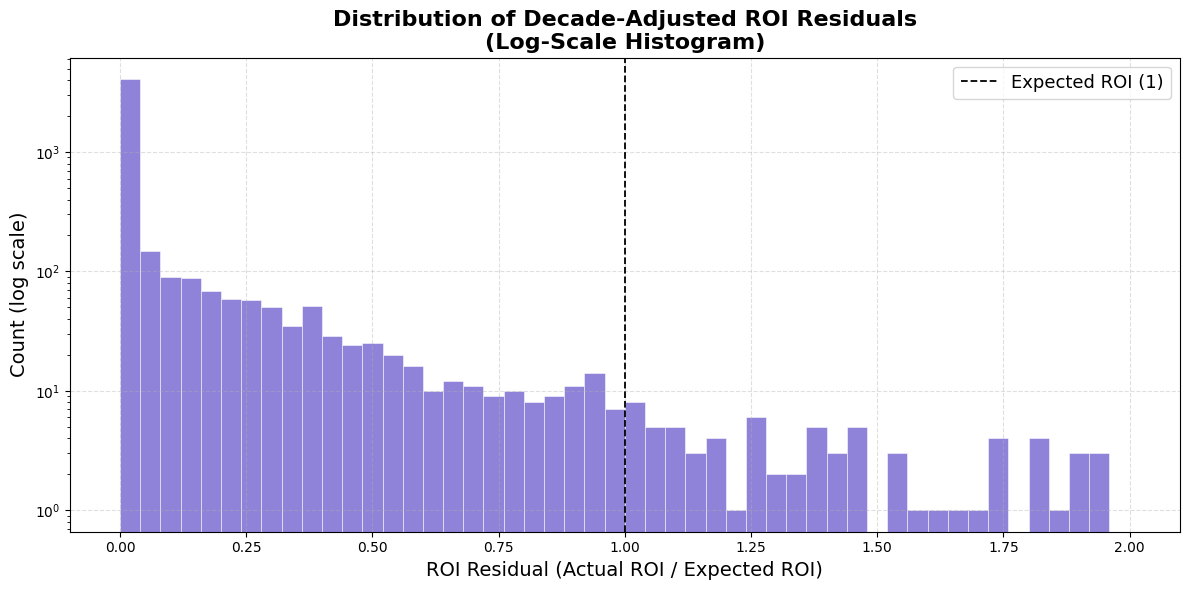


Summary Statistics:
count    5.072000e+03
mean     1.000000e+00
std      3.214114e+01
min      2.199574e-10
25%      3.084296e-04
50%      1.014718e-03
75%      4.533366e-03
max      1.769593e+03
Name: roi_residual, dtype: float64


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from google.cloud import bigquery

# --------------------------------------------------------------
# Load the ROI residuals table from BigQuery
# --------------------------------------------------------------
client = bigquery.Client(project="cs-145-project-fall-25")

query = """
    SELECT roi_residual
    FROM `cs-145-project-fall-25.uploaded_movie_data.roi_residuals_by_decade`
    WHERE roi_residual IS NOT NULL
"""
df = client.query(query).to_dataframe()

# --------------------------------------------------------------
# Plot: Log-scale histogram of ROI residuals
# --------------------------------------------------------------
plt.figure(figsize=(12, 6))

plt.hist(
    df['roi_residual'],
    bins=50,               # more bins for detail
    range=(0,2),
    color="slateblue",
    alpha=0.75,
    edgecolor="white",
    linewidth=0.5
)

plt.yscale('log')          # <-- key line: log scale for tails

plt.axvline(
    1,
    color="black",
    linestyle="--",
    linewidth=1.3,
    label="Expected ROI (1)"
)

plt.title(
    "Distribution of Decade-Adjusted ROI Residuals\n(Log-Scale Histogram)",
    fontsize=16,
    fontweight="bold"
)

plt.xlabel("ROI Residual (Actual ROI / Expected ROI)", fontsize=14)
plt.ylabel("Count (log scale)", fontsize=14)

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=13)

plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# Optional: Show summary stats for writeup
# --------------------------------------------------------------
print("\nSummary Statistics:")
print(df['roi_residual'].describe())


Our conclusion from this plot is that the movie industry is *heavily dependent on blockbusters and outperformers.* Most movies actually *underperform* their expected decade-adjusted return on investment, as there is a heavy skew in the distribution between 0 and 1, so it is really the outliers that make the industry move.

## Query #8 [CTEs, Window Functions]: Is There Any Correlation Between GDP Change and Movie Revenue Change Per Year?

We conclude this section with two additional, related queries using our macroeconomic indicators dataset from FRED (Federal Reserve Economic Data). Specifically, we plot yearly change in real GDP (query #8) and consumer sentiment (query #9) versus yearly change in inflation-adjusted average movie revenue.

In [18]:
%%bigquery --project $project_id
WITH rois AS (
  SELECT
    EXTRACT(YEAR FROM mm.release_date) AS release_year,
    fd.observation_date,
    fd.real_gdp AS real_gdp,
    fd.cpi AS cpi,

    -- Base CPI from earliest observation in the FRED table
    FIRST_VALUE(fd.cpi) OVER (ORDER BY fd.observation_date) AS base_cpi,

    mm.revenue AS revenue
  FROM `cs-145-project-fall-25.uploaded_movie_data.movies_metadata` mm
  JOIN `cs-145-project-fall-25.macroeconomics.fred_data` fd
    ON EXTRACT(YEAR FROM mm.release_date) = EXTRACT(YEAR FROM fd.observation_date)
  WHERE mm.budget > 0 AND mm.revenue > 0
),

gdp_vs_revenue AS (
  SELECT
    release_year,
    ROUND(AVG(real_gdp), 4) AS avg_annual_real_gdp,

    -- inflation-adjusted movie revenue
    ROUND(AVG(revenue * base_cpi / cpi), 4) AS avg_annual_adjusted_movie_revenue
  FROM rois
  GROUP BY release_year
)

SELECT
  release_year,

  -- YoY GDP Change
  (avg_annual_real_gdp - LAG(avg_annual_real_gdp) OVER (ORDER BY release_year))
    / LAG(avg_annual_real_gdp) OVER (ORDER BY release_year)
    AS real_gdp_yoy_change,

  -- YoY Inflation-Adjusted Movie Revenue Change
  (avg_annual_adjusted_movie_revenue - LAG(avg_annual_adjusted_movie_revenue) OVER (ORDER BY release_year))
    / LAG(avg_annual_adjusted_movie_revenue) OVER (ORDER BY release_year)
    AS movie_revenue_yoy_change

FROM gdp_vs_revenue
ORDER BY release_year;

Query is running:   0%|          |

Downloading:   0%|          |

,release_year,real_gdp_yoy_change,movie_revenue_yoy_change
0,1947,NaN,NaN
1,1948,0.041203,-0.623547
2,1949,-0.005583,1.606107
3,1950,0.086919,4.619438
4,1951,0.080450,0.430621
...,...,...,...
66,2013,0.021178,-0.072439
67,2014,0.025238,0.047534
68,2015,0.029455,0.098549
69,2016,0.018195,-0.062140


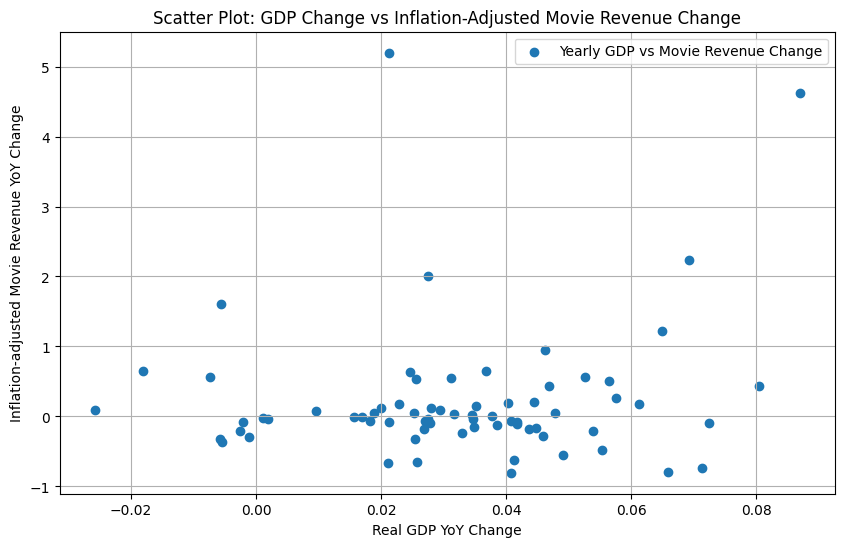

In [19]:
# ------------------------------------------
# 1. Imports
# ------------------------------------------
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------
# 2. Initialize BigQuery client
# ------------------------------------------
client = bigquery.Client(project=project_id)

# ------------------------------------------
# 3. Query your results table
# ------------------------------------------
query = """
SELECT
  release_year,
  real_gdp_yoy_change,
  movie_revenue_yoy_change
FROM `cs-145-project-fall-25.uploaded_movie_data.gdp_vs_movie_revenue`
WHERE release_year IS NOT NULL
ORDER BY release_year
"""

df = client.query(query).to_dataframe()

# ------------------------------------------
# 4. Scatter plot: GDP change vs Movie revenue change
# ------------------------------------------
plt.figure(figsize=(10, 6))

plt.scatter(
    df["real_gdp_yoy_change"],
    df["movie_revenue_yoy_change"],
    label="Yearly GDP vs Movie Revenue Change"
)

plt.xlabel("Real GDP YoY Change")
plt.ylabel("Inflation-adjusted Movie Revenue YoY Change")
plt.title("Scatter Plot: GDP Change vs Inflation-Adjusted Movie Revenue Change")
plt.grid(True)
plt.legend()

plt.show()



## Query #9 [CTEs, Window Functions]: Is There Any Correlation Between Consumer Sentiment and Movie Revenue Change Per Year?

A more general question: what are the economics of the Hollywood movie industry? Specifically, we want to know how much better of worse movies do *relative to their expected return on investment.* To quantify this, we determine the average return on investment (revenue / budget) *per decade*, and then use a correlated subquery to compute each movie's *residual* (actual return on investment / expected return on investment by decade of movie). This ensures that a residual of 1 represents a movie performing averagely. Finally, we visualize this decade-adjusted residual in a histogram, restricting the range to prevent too much clustering near 1. Yes, there will be a few outliers missing, but this still does not prevent understanding of the statistics.

Also, this query only uses one of our new tables (movies_metadata), so no JOINs here. However, the insights are still very interesting.

In [20]:
%%bigquery --project $project_id
WITH stats AS (
  SELECT
    EXTRACT(YEAR FROM mm.release_date) AS release_year,
    fd.observation_date,
    fd.cpi AS cpi,

    -- Base CPI from earliest observation in the FRED table
    FIRST_VALUE(fd.cpi) OVER (ORDER BY fd.observation_date) AS base_cpi,

    fd.sent AS sentiment,
    mm.revenue AS revenue
  FROM `cs-145-project-fall-25.uploaded_movie_data.movies_metadata` mm
  JOIN `cs-145-project-fall-25.macroeconomics.fred_data` fd
    ON EXTRACT(YEAR FROM mm.release_date) = EXTRACT(YEAR FROM fd.observation_date)
  WHERE mm.budget > 0 AND mm.revenue > 0
),

gdp_vs_revenue AS (
  SELECT
    release_year,
    AVG(sentiment) AS avg_consumer_sentiment,

    -- inflation-adjusted movie revenue
    ROUND(AVG(revenue * base_cpi / cpi), 4) AS avg_annual_adjusted_movie_revenue
  FROM stats
  GROUP BY release_year
)

SELECT
  release_year,

  -- YoY GDP Change
  (avg_consumer_sentiment - LAG(avg_consumer_sentiment) OVER (ORDER BY release_year))
    / LAG(avg_consumer_sentiment) OVER (ORDER BY release_year)
    AS consumer_sentiment_change,

  -- YoY Inflation-Adjusted Movie Revenue Change
  (avg_annual_adjusted_movie_revenue - LAG(avg_annual_adjusted_movie_revenue) OVER (ORDER BY release_year))
    / LAG(avg_annual_adjusted_movie_revenue) OVER (ORDER BY release_year)
    AS movie_revenue_yoy_change

FROM gdp_vs_revenue
ORDER BY release_year;

Query is running:   0%|          |

Downloading:   0%|          |

,release_year,consumer_sentiment_change,movie_revenue_yoy_change
0,1947,NaN,NaN
1,1948,NaN,-0.623547
2,1949,NaN,1.606107
3,1950,NaN,4.619438
4,1951,NaN,0.430621
...,...,...,...
66,2013,0.007183,-0.072439
67,2014,0.082658,0.047534
68,2015,0.129042,0.098549
69,2016,-0.050119,-0.062140


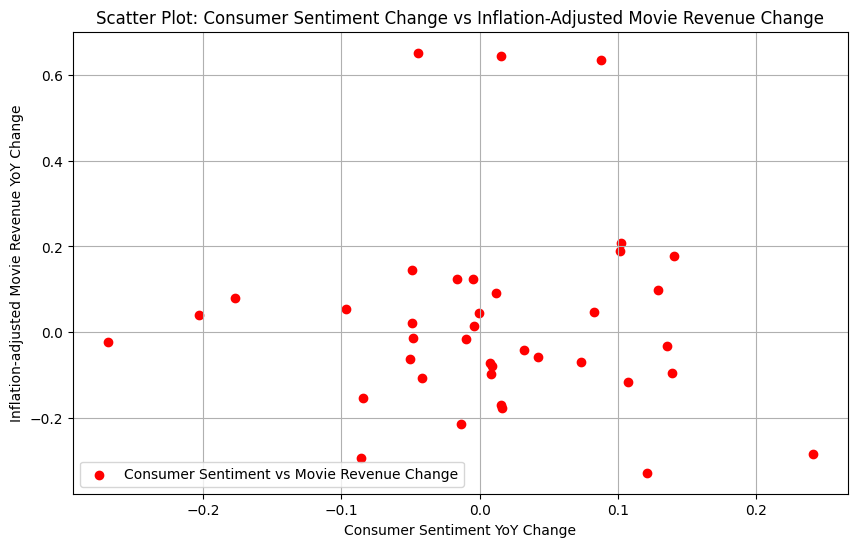

In [21]:
# ------------------------------------------
# 1. Imports
# ------------------------------------------
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------
# 2. Initialize BigQuery client
# ------------------------------------------
client = bigquery.Client(project=project_id)

# ------------------------------------------
# 3. Query your results table
# ------------------------------------------
query = """
SELECT
  release_year,
  consumer_sentiment_change,
  movie_revenue_yoy_change
FROM `cs-145-project-fall-25.uploaded_movie_data.sentiment_vs_movie_revenue`
WHERE release_year IS NOT NULL
ORDER BY release_year
"""

df = client.query(query).to_dataframe()

# ------------------------------------------
# 4. Scatter plot: GDP change vs Movie revenue change
# ------------------------------------------
plt.figure(figsize=(10, 6))

plt.scatter(
    df["consumer_sentiment_change"],
    df["movie_revenue_yoy_change"],
    label="Consumer Sentiment vs Movie Revenue Change",
    color='red'
)

plt.xlabel("Consumer Sentiment YoY Change")
plt.ylabel("Inflation-adjusted Movie Revenue YoY Change")
plt.title("Scatter Plot: Consumer Sentiment Change vs Inflation-Adjusted Movie Revenue Change")
plt.grid(True)
plt.legend()

plt.show()



It seems like that there is little, if any, relationship between either macroeconomic indicator and movie revenue. An optimistic view would settle for a weak positive linear relationship.

# Section 4: ML Predictions in BigQuery (2 Different Models)


## Model #1: Find the Next Great Book to Adapt into a Feature Film

How successful will a movie adaptation of a work of fiction be? To answer this question for Gru, we define a "success score" similar to the one in Section 3, but weighted more heavily towards return on investment:
<center>
0.5 * log(roi + 1) + 0.3 * rating + 0.2 * popularity,
</center>
where "popularity" is a metric on TMDB that tracks lifetime interest for a movie (it could be indicative of positive or negative publicity, hence the lower weight in the success score). And again, return on investment is calculated as revenue / budget. We use the log-normal version of roi to reduce the success score to a reasonable range.

This will be our dependent variable for our *linear regression* ML model. Independent variables will cover a wide range of features, which are -- importantly -- *related only to the source material on which the movie is based*. This is to prevent data leakage, for if any movie feature ends up filtering into our model (like budget, revenue, or rating), it will become biased and deliver nearly accurate predictions on only the training dataset. Features we will use include the number of genres the book spans, awards it has won, user rating, whether the author is a GoodReads author, and an interesting engineered feature (that employs a correlated subquery!) to determine whether a book is written in a popular genre.

The training dataset is not very large, just under 700 rows. This is certainly on the paltry side for machine learning, but not prohibitively. But BigQuery prefers an 80-20 split between training and evaluation for datasets of this size, so we mark each row as one to be used for training or evaluation via a Bernoulli random variable with p=0.8.

Once the model is trained, and statistics are gathered, we turn to the goodreads_best_books_ever table and extract all books that have never been adapted before according to Wikipedia (this is done using a NOT IN clause to remove books from our adaptation training set). Next, we run the model on this test set and return the *top 25 books Gru can look to adapt for his filmmaking endeavor*.

Here is the full pipeline.



Create book-to-movie-adaptations training dataset.

In [10]:
# This SQL query creates a BigQuery table named 'adaptation_training_data'
# in the 'machine_learning' dataset. This table is designed to serve as a training dataset
# for a Machine Learning model that predicts the success of book-to-movie adaptations.
# It combines various features from book metadata (Goodreads) and movie metadata (TMDB, IMDb).

%%bigquery --project $project_id

CREATE OR REPLACE TABLE
  `cs-145-project-fall-25.machine_learning.adaptation_training_data` AS
WITH imdb_dedup AS (
  SELECT *
  FROM `bigquery-public-data.imdb.title_basics`
  QUALIFY ROW_NUMBER() OVER (
    PARTITION BY LOWER(primary_title)
    ORDER BY start_year DESC
  ) = 1
),

tmdb_dedup AS (
  SELECT *
  FROM `cs-145-project-fall-25.uploaded_movie_data.movies_metadata`
  QUALIFY ROW_NUMBER() OVER (
    PARTITION BY imdb_id
    ORDER BY release_date DESC
  ) = 1
),

base AS (
  SELECT
    bma.gr_title AS book_title,
    bma.author AS book_author,
    bma.gr_avg_rating AS book_avg_rating,
    gbb.likedpercent AS book_liked_percentage,
    bma.book_year,

    JSON_EXTRACT_ARRAY(gbb.awards) AS award_list,
    JSON_EXTRACT_ARRAY(gbb.genres) AS genre_list,
    JSON_EXTRACT_ARRAY(gbb.ratingsbystars) AS star_list,

    ARRAY_LENGTH(JSON_EXTRACT_ARRAY(gbb.awards)) AS awards_count,
    ARRAY_LENGTH(JSON_EXTRACT_ARRAY(gbb.genres)) AS genre_count,

    CASE
      WHEN LOWER(gbb.author) LIKE '%(goodreads author)%' THEN 1
      ELSE 0
    END AS is_goodreads_author,

    mm.revenue,
    mm.budget,
    SAFE_DIVIDE(mm.revenue, mm.budget) AS roi,
    GREATEST(tr.average_rating, mm.vote_average) AS rating,
    mm.popularity AS tmdb_popularity

  FROM `cs-145-project-fall-25.uploaded_movie_data.book_to_movie_adaptations` bma
  JOIN `cs-145-project-fall-25.uploaded_movie_data.goodreads_best_books_ever` gbb
    ON bma.book_title = gbb.title
  JOIN imdb_dedup tb
    ON LOWER(bma.film_title) = LOWER(tb.primary_title)
  JOIN `bigquery-public-data.imdb.title_ratings` tr
    ON tb.tconst = tr.tconst
  JOIN tmdb_dedup mm
    ON mm.imdb_id = tb.tconst

  WHERE mm.budget > 0
    AND mm.revenue IS NOT NULL
    AND tr.num_votes >= 500
),

genre_counts AS (
  -- CTE: `genre_counts` calculates the total count of books for each genre from Goodreads.
  -- This helps in identifying popular genres.
  SELECT
    JSON_EXTRACT_SCALAR(genre, '$') AS genre,
    COUNT(DISTINCT bma.gr_title) AS genre_book_count
  FROM `cs-145-project-fall-25.uploaded_movie_data.book_to_movie_adaptations` bma
  INNER JOIN `cs-145-project-fall-25.uploaded_movie_data.goodreads_best_books_ever` gbb
      ON bma.book_title = gbb.title
  CROSS JOIN UNNEST(JSON_EXTRACT_ARRAY(gbb.genres)) AS genre -- Unnest genres to count each one individually
  GROUP BY genre
),

total_books AS (
  -- CTE: `total_books` simply counts the total number of unique books in the dataset.
  SELECT COUNT(DISTINCT bma.gr_title) AS total
  FROM `cs-145-project-fall-25.uploaded_movie_data.book_to_movie_adaptations` bma
),

popular_genres AS (
  -- CTE: `popular_genres` identifies genres as 'popular' if their book count exceeds a certain proportion (here, 25%) of all books.
  SELECT
    gc.genre,
    gc.genre_book_count,
    gc.genre_book_count / total_books.total AS proportion,
    CASE WHEN gc.genre_book_count / total_books.total > 0.25 THEN 1 ELSE 0 END AS is_popular_genre
  FROM genre_counts gc CROSS JOIN total_books
),

final AS (
  -- CTE: `final` combines all features and calculates the ultimate 'success_score'.
  SELECT
    *,
    (
      -- Calculates the proportion of a book's genres that are considered 'popular'.
      -- This is a nested subquery that iterates through each book's genre list.
      SELECT
        IF(genre_count = 0, 0,
          COUNT(*) / genre_count
        ) -- Avoid division by zero if genre_count is 0
      FROM UNNEST(genre_list) AS g
      JOIN popular_genres pg
        ON JSON_EXTRACT_SCALAR(g, '$') = pg.genre
      WHERE pg.is_popular_genre = 1
    ) AS popular_genre_proportion,

    -- `success_score`: A composite metric indicating movie success,
    -- weighted towards ROI, with rating and popularity also contributing.
    -- LOG(roi + 1) is used to handle the wide range of ROI values and dampen extreme outliers.
    0.5 * LOG(roi + 1) + -- 50% weight on (log-transformed) ROI
    0.3 * rating +       -- 30% weight on combined rating
    0.2 * tmdb_popularity AS success_score -- 20% weight on TMDB popularity
  FROM base
)

-- Final selection: Retrieve all calculated features and the success score for the training table.
SELECT * FROM final;

Query is running:   0%|          |

""


Split dataset into "train" and "eval."

In [11]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE
  `cs-145-project-fall-25.machine_learning.adaptation_split_training_data` AS
SELECT
  *,
  -- Use RAND() to generate a random number between 0 and 1.
  -- If the random number is less than 0.8, assign 'TRUE' for the 'split' column,
  -- indicating it's part of the training set (approximately 80% of data).
  -- Otherwise, it will be 'FALSE', indicating it's part of the evaluation set (approximately 20% of data).
  (RAND() < 0.8) AS split  -- BOOL for custom split
FROM `cs-145-project-fall-25.machine_learning.adaptation_training_data`
WHERE success_score IS NOT NULL;

Query is running:   0%|          |

""


Set up the ML model.

In [12]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL
  `cs-145-project-fall-25.machine_learning.adaptation_success_model`
OPTIONS(
  model_type='linear_reg',
  input_label_cols=['success_score']
) AS
SELECT
  -- Label
  success_score,

  -- BOOK FEATURES
  book_avg_rating,
  book_year,
  book_liked_percentage,
  awards_count,
  is_goodreads_author,
  popular_genre_proportion

FROM `cs-145-project-fall-25.machine_learning.adaptation_split_training_data`
WHERE split = True;

Query is running:   0%|          |

""


In [13]:
%%bigquery --project $project_id

SELECT * FROM ML.TRAINING_INFO(MODEL `cs-145-project-fall-25.machine_learning.adaptation_success_model`)

Query is running:   0%|          |

Downloading:   0%|          |

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,3,5.617545,2.336592,0.8,1990
1,0,2,5.813802,2.447206,0.8,1966
2,0,1,10.587193,6.488247,0.4,2129
3,0,0,19.564437,14.623746,0.2,1942


Evaluate the model.

In [14]:
%%bigquery --project $project_id

SELECT * FROM ML.EVALUATE(MODEL `cs-145-project-fall-25.machine_learning.adaptation_success_model`)

Query is running:   0%|          |

Downloading:   0%|          |

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,1.134052,2.336592,0.076972,0.884478,0.034206,0.035777


Create an unadapted books test set and run the model on it for new predictions.

In [15]:
%%bigquery --project $project_id

WITH adapted AS (
  SELECT DISTINCT gr_title AS book_title, author as book_author
  FROM `cs-145-project-fall-25.uploaded_movie_data.book_to_movie_adaptations`
  WHERE gr_title IS NOT NULL
),

goodreads_clean AS (
  SELECT
    title AS book_title,
    author AS book_author,
    rating AS book_avg_rating,
    likedpercent AS book_liked_percentage,
    EXTRACT(YEAR FROM publishdate) AS book_year,

    JSON_EXTRACT_ARRAY(genres) AS genre_list,
    ARRAY_LENGTH(JSON_EXTRACT_ARRAY(genres)) AS genre_count,
    JSON_EXTRACT_ARRAY(awards) AS awards,
    ARRAY_LENGTH(JSON_EXTRACT_ARRAY(awards)) AS awards_count,
    CASE
      WHEN LOWER(author) LIKE '%(goodreads author)%' THEN 1 ELSE 0
    END AS is_goodreads_author
  FROM `cs-145-project-fall-25.uploaded_movie_data.goodreads_best_books_ever`
  WHERE rating IS NOT NULL AND language = 'English'

    -- Filter out all nonfiction categories
    AND EXISTS (
      SELECT 1
      FROM UNNEST(JSON_EXTRACT_ARRAY(genres)) AS g
      WHERE JSON_EXTRACT_SCALAR(g, '$') IN (
        'Fiction'
      )
    )
    AND language = 'English'
),

-- Remove books that have already been adapted
unadapted_books AS (SELECT *
  FROM goodreads_clean
  WHERE book_title NOT IN (SELECT book_title FROM adapted) AND genre_count > 0
),

genre_counts AS (
  SELECT
    JSON_EXTRACT_SCALAR(genre, '$') AS genre,
    COUNT(DISTINCT bma.gr_title) AS genre_book_count
  FROM `cs-145-project-fall-25.uploaded_movie_data.book_to_movie_adaptations` bma
  JOIN `cs-145-project-fall-25.uploaded_movie_data.goodreads_best_books_ever` gbb
      ON bma.book_title = gbb.title
  CROSS JOIN UNNEST(JSON_EXTRACT_ARRAY(gbb.genres)) AS genre
  GROUP BY genre
),

total_books AS (
  SELECT COUNT(DISTINCT gr_title) AS total
  FROM `cs-145-project-fall-25.uploaded_movie_data.book_to_movie_adaptations`
),

popular_genres AS (
  SELECT
    gc.genre,
    gc.genre_book_count,
    gc.genre_book_count / total_books.total AS proportion,
    CASE WHEN gc.genre_book_count / total_books.total > 0.05 THEN 1 ELSE 0 END AS is_popular_genre
  FROM genre_counts gc
  CROSS JOIN total_books
),

prediction_ready AS (
  SELECT
    ub.*,
    (
      SELECT
        IF(genre_count = 0, 0,
          COUNT(*) / genre_count
        )
      FROM UNNEST(genre_list) AS g
      JOIN popular_genres pg
        ON JSON_EXTRACT_SCALAR(g, '$') = pg.genre
      WHERE pg.is_popular_genre = 1
    ) AS popular_genre_proportion
  FROM unadapted_books ub
)

SELECT
  book_title,
  book_author,
  book_avg_rating,
  genre_list,
  predicted_success_score
FROM ML.PREDICT(
  MODEL `cs-145-project-fall-25.machine_learning.adaptation_success_model`,
  TABLE prediction_ready
)
ORDER BY predicted_success_score DESC
LIMIT 25;

Query is running:   0%|          |

Downloading:   0%|          |

,book_title,book_author,book_avg_rating,genre_list,predicted_success_score
0,The Hunger Games,Suzanne Collins,4.33,"[""Young Adult"", ""Fiction"", ""Dystopia"", ""Fantas...",6.772597
1,Harry Potter and the Sorcerer's Stone,"J.K. Rowling, Mary GrandPré (Illustrator)",4.47,"[""Fantasy"", ""Fiction"", ""Young Adult"", ""Magic"",...",6.190435
2,The Book Thief,Markus Zusak (Goodreads Author),4.37,"[""Historical Fiction"", ""Fiction"", ""Young Adult...",5.900317
3,The Fault in Our Stars,John Green (Goodreads Author),4.21,"[""Young Adult"", ""Romance"", ""Fiction"", ""Contemp...",5.860744
4,The Hate U Give,Angie Thomas (Goodreads Author),4.52,"[""Young Adult"", ""Fiction"", ""Contemporary"", ""Au...",5.819625
5,"Onyx Webb: Book Two: Episodes 4, 5, 6","Richard Fenton (Goodreads Author), Andrea Walt...",4.68,"[""Horror"", ""Suspense"", ""Paranormal"", ""Thriller...",5.743284
6,Escape from Mr. Lemoncello's Library,Chris Grabenstein (Goodreads Author),4.13,"[""Middle Grade"", ""Mystery"", ""Fiction"", ""Childr...",5.725628
7,The Traitor,Kimberley Chambers (Goodreads Author),4.61,"[""Crime"", ""Thriller"", ""Romance"", ""Mystery"", ""F...",5.722534
8,Book Too: Because of Grandmother,Ali Marsman (Goodreads Author),4.90,"[""Fiction""]",5.682625
9,Throne of Glass Collection,Sarah J. Maas (Goodreads Author),4.75,"[""New Adult"", ""Fiction"", ""Fantasy"", ""Romance"",...",5.679013


**How Sharp Is Our Book-to-Movie Prediction Machine, Actually?**

We'll call this more of a "vibes model." From a strictly technical point of view, the linear regression model shows modest but real learning: the low, positive R² of 0.034 and explained variance of 0.035 confirm that the model captured a very weak signal rather than pure noise, even though most of the variance in adaptation success remains driven by factors we didn’t (and probably realistically couldn’t) model. And truth be told, adapting a book for a feature film is a highly variant process, with some adaptations being incredibly successful and others failing miserably. People have high expectations of their adapted source material!

Also, you may be wondering why The Hunger Games, Harry Potter, and The Hate U Give show up among the top candidates when they have clearly been adapted. We were concerned, too, about this, but we quickly found out that it is not a problem with our model or a symptom of leakage. It just so happened that because the web scraping script detailed in Section 2 was designed to filter out malformed titles and authors or NULL fields so that a viable table could be uploaded to BigQuery, some famous titles were scrapped. Therefore, The Hunger Games is actually not present in our book_to_movie_adaptations table and the model certainly was not trained on this data point. In fact, this points to some measure of success with our model, that even when some noteworthy adaptations are left out, it is able to find and accurately evaluate their source material is adaptation-worthy!

The relatively low mean squared log error of 0.077 is the real win here — it tells us that while the model isn’t a perfect ranker of future cinematic masterpieces, it generally keeps its predictions in the correct scale and avoids wild, unrealistic estimates.

The top five books that the model recommends for adaptation are all high rated on GoodReads and mostly written by GoodReads authors, encompassing popular genres like crime and romance. So Gru can definitely look at some of these for his screenwriting minions.

Where the model becomes genuinely useful is as a ranking engine rather than an oracle. When applied to books that have never been adapted, it produces a surprisingly reasonable short list of high-potential candidates by leaning heavily on structured features like average reader ratings, genre composition, and author-level patterns. In other words, it behaves less like a fortune teller and more like a very ambitious junior studio executive: not always right, but consistently helpful and outgoing — which may be worth something to Gru.

## Model #2: Predict Whether a Movie Will Be a Hit

<p>
Now for the piece de resistance.

Gru, being both ambitious and chronically short on time, wanted to know: <em>can we predict whether a movie will be a hit before it ever hits theaters?</em> To answer this, we built a machine learning model that tries to guess a film’s success using only information that would have been available <strong>before release</strong> — because cheating with box office data would be… well… cheating.
</p>

<p>
First, we defined what a “hit” actually means. We built a custom <strong>success score</strong> that blends profitability with audience perception:
</p>

<center>
0.6 × normalized(log(ROI + 1)) + 0.4 × (rating / 10)
</center>

<p>
Here, ROI is revenue divided by budget, and the log transform keeps the wildly successful outliers from blowing up the scale. If a movie’s score crosses a threshold, it earns the coveted label of “hit” — our target variable.
</p>

<p>
The fun part was building features that Gru could realistically rely on <em>ahead of time</em>. We came full cycle here by integrating Rishubh's Project 1 into the feature engineering. We decided upon the following signals:</p>
<ul>
  <li>Cast size and presence of consistently strong actors (using one of the queries from Project 1!) </li>
  <li>Whether the director was among the top performers of their decade (using another one of the queries from Project 1!) </li>
  <li>Studio track record</li>
  <li>A carefully designed <strong>crew prolificity</strong> metric that measures how experienced a film’s crew was <em>at that point in time</em> (computed using window functions to avoid time travel and data leakage)</li>
  <li>Year-over-year macroeconomic trends from FRED rather than raw economic levels</li>
  <li>A Gemini-powered semantic feature that flags whether a movie is “family-friendly” based on text analysis; this was obtained via batch inference with Vertex AI, where we fed the themes, genres, and description of each movie into Gemini 2.5 Flash as a JSONL file and asked it to rate the movie as family-friendly or not.</li> The results of the sentiment analysis job are shown in the screenshot below; the output of the natural language processing was JSONL file of responses from Gemini exported to Google Cloud Storage, which we converted into a BigQuery table.
</ul>

To engineer all of this, we joined the Letterboxd, IMDB, TMDB, and FRED datasets. The query to create the training table is an excellent example of an array of intermediate-to-advanced SQL techniques, including correlated subqueries, window functions, CTEs, coalescing, and aggregating.
<p>
After some intense battles with BigQuery (and a few near-meltdowns), we stabilized the pipeline, ensured each movie appeared exactly once, and trained a logistic regression model. We trained on movies released before 2005 and evaluated on later films to simulate real-world deployment.
</p>

<p>
The final model achieved about <strong>72% accuracy</strong> and a <strong>0.54 log loss</strong>, outperforming the base “guess everything is a hit” strategy. The strongest predictors ended up being crew experience, directorial pedigree, and economic growth conditions — suggesting that even supervillains should hire experienced teams and release their films during good economic times.
</p>

<p>
In conclusion: Gru should not blindly trust vibes. Data is a much better sidekick.
</p>

<h3>Full Pipeline (for reference)</h3>
<p>
Below is the full SQL pipeline used to engineer features and train the model. We begin by creating the base table with just the data from Letterboxd, IMDB, TMDB, and FRED.
</p>



In [16]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE
  `cs-145-project-fall-25.machine_learning.movie_hit_features` AS

-- Base CTE to get Letterboxd movie IDs, names, release years, and a unique movie key.
-- This serves as the foundation for joining other data sources.
WITH base_movies AS (
  SELECT
    lm.id AS letterboxd_id,
    lm.name,
    EXTRACT(YEAR FROM r.date) AS release_year,
    CONCAT(lm.id, '_', lm.name, '_', CAST(EXTRACT(YEAR FROM r.date) AS STRING)) AS movie_key
  FROM `cs-145-project-fall-25.uploaded_movie_data.letterboxd_movies` lm
  LEFT JOIN `cs-145-project-fall-25.uploaded_movie_data.letterboxd_releases` r
    ON lm.id = r.id
),

-- CTE to map Letterboxd movies to external data sources (TMDB and IMDb).
-- It retrieves budget, revenue, ratings (coalescing IMDb and TMDB), and runtime.
-- A fuzzy match on movie title and release year is used for TMDB join.
external_maps AS (
  SELECT
    bm.*,
    tmdb.budget,
    tmdb.revenue,
    COALESCE(imdb.average_rating, tmdb.vote_average) AS rating, -- Prioritize IMDb rating, fall back to TMDB
    COALESCE(tb.runtime_minutes, lm.minute) AS runtime
  FROM base_movies bm
  LEFT JOIN `cs-145-project-fall-25.uploaded_movie_data.movies_metadata` tmdb
    ON
      bm.name = tmdb.title
      AND ABS(EXTRACT(YEAR FROM tmdb.release_date) - bm.release_year) <= 1 -- Allow for slight year discrepancy
  LEFT JOIN `bigquery-public-data.imdb.title_ratings` imdb
    ON tmdb.imdb_id = imdb.tconst
  LEFT JOIN `bigquery-public-data.imdb.title_basics` tb
    ON imdb.tconst = tb.tconst
  LEFT JOIN `cs-145-project-fall-25.uploaded_movie_data.letterboxd_movies` lm -- Join back to letterboxd_movies for runtime if not found in IMDb
    ON bm.letterboxd_id = lm.id
),

-- CTE to extract actor-related features for each movie.
-- Includes the count of actors and a flag if any 'consistently good actor' is present.
actors AS (
  SELECT
    id AS letterboxd_id,
    COUNT(DISTINCT name) AS num_actors,
    MAX(CASE WHEN cga.actor_name IS NOT NULL THEN 1 ELSE 0 END) AS has_consistently_good_actor
  FROM `cs-145-project-fall-25.uploaded_movie_data.letterboxd_actors` a
  LEFT JOIN `cs-145-project-fall-25.uploaded_movie_data.consistently_good_actors` cga
    ON a.name = cga.actor_name
  GROUP BY id
),

-- CTE to flag movies with a 'top 5 director' from a predefined list for each decade.
director_flags AS (
  SELECT
    id AS letterboxd_id,
    MAX(CASE WHEN tfd.director_name IS NOT NULL THEN 1 ELSE 0 END) AS has_top5_director
  FROM `cs-145-project-fall-25.uploaded_movie_data.letterboxd_crew` c
  LEFT JOIN `cs-145-project-fall-25.uploaded_movie_data.top_five_directors_per_decade` tfd
    ON c.name = tfd.director_name
  WHERE c.role = 'Director'
  GROUP BY id
),

-- CTE to calculate the total movie output for each studio.
studio_stats AS (
  SELECT
    studio,
    COUNT(DISTINCT id) AS studio_output
  FROM `cs-145-project-fall-25.uploaded_movie_data.letterboxd_studios`
  GROUP BY studio
),

-- CTE to retrieve movie text data (e.g., descriptions for sentiment analysis).
movie_text AS (
  SELECT DISTINCT
    id AS letterboxd_id,
    movie_text
  FROM `cs-145-project-fall-25.uploaded_movie_data.letterboxd_movie_text`
),

-- CTE to calculate year-over-year changes in macroeconomic indicators.
-- This involves an inner subquery to get annual averages, then a window function for YOY change.
macro AS (
  SELECT
    year,

    avg_real_gdp,
    avg_real_gni,
    avg_real_dpi,
    avg_real_pce,
    avg_sentiment,

    SAFE_DIVIDE(avg_real_gdp - LAG(avg_real_gdp) OVER (ORDER BY year),
                LAG(avg_real_gdp) OVER (ORDER BY year)) AS yoy_real_gdp,

    SAFE_DIVIDE(avg_real_gni - LAG(avg_real_gni) OVER (ORDER BY year),
                LAG(avg_real_gni) OVER (ORDER BY year)) AS yoy_real_gni,

    SAFE_DIVIDE(avg_real_dpi - LAG(avg_real_dpi) OVER (ORDER BY year),
                LAG(avg_real_dpi) OVER (ORDER BY year)) AS yoy_real_dpi

  FROM (
    SELECT
      EXTRACT(YEAR FROM observation_date) AS year,
      AVG(real_gdp) AS avg_real_gdp,
      AVG(real_gni) AS avg_real_gni,
      AVG(real_dpi) AS avg_real_dpi,
      AVG(SAFE_CAST(real_pce AS FLOAT64)) AS avg_real_pce,
      AVG(sent) AS avg_sentiment
    FROM `cs-145-project-fall-25.macroeconomics.fred_data`
    GROUP BY year
  )
),

-- CTE to calculate each crew member's career prolificity up to the release year of a movie.
-- Uses a window function to avoid data leakage (only counts prior movies).
crew_career_stats AS (
  SELECT
    c.name,
    c.id AS letterboxd_id,
    bm.release_year,
    COUNT(*) OVER (
      PARTITION BY c.name
      ORDER BY bm.release_year
      ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
    ) AS career_movies_to_date
  FROM `cs-145-project-fall-25.uploaded_movie_data.letterboxd_crew` c
  JOIN base_movies bm
    ON c.id = bm.letterboxd_id
),

-- CTE to aggregate the average career prolificity for the crew of each movie.
crew_movie_agg AS (
  SELECT
    letterboxd_id,
    AVG(career_movies_to_date) AS avg_crew_prolificity
  FROM crew_career_stats
  GROUP BY letterboxd_id
)

-- Main SELECT statement to combine all features and calculate the target variables.
SELECT
  em.movie_key,
  em.letterboxd_id AS id,
  em.name,
  mt.movie_text, -- Movie description for potential sentiment analysis
  em.release_year,
  em.runtime,
  em.budget,
  em.revenue,
  em.rating,

  SAFE_DIVIDE(em.revenue, em.budget) AS roi,

  -- Calculate a composite 'success_score' combining normalized ROI (log-transformed) and rating.
  -- Weights: 60% on ROI, 40% on rating.
  (
    0.6 * (LN(SAFE_DIVIDE(em.revenue, em.budget) + 1) /
           (LN(SAFE_DIVIDE(em.revenue, em.budget) + 1) + 1))
    + 0.4 * (em.rating / 10)
  ) AS success_score,

  -- Determine if a movie is a 'hit' based on a threshold of the success_score (0.6).
  CASE WHEN (
    0.6 * (LN(SAFE_DIVIDE(em.revenue, em.budget) + 1) /
           (LN(SAFE_DIVIDE(em.revenue, em.budget) + 1) + 1))
    + 0.4 * (em.rating / 10)
  ) > 0.6 THEN 1 ELSE 0 END AS hit,

  a.num_actors,
  a.has_consistently_good_actor,
  d.has_top5_director,

  -- Subquery to get the maximum studio output for the studios associated with the movie.
  (
    SELECT MAX(ss.studio_output)
    FROM `cs-145-project-fall-25.uploaded_movie_data.letterboxd_studios` s
    JOIN studio_stats ss ON s.studio = ss.studio
    WHERE s.id = em.letterboxd_id
  ) AS studio_output,

  cma.avg_crew_prolificity,

  -- Year-over-year macroeconomic changes as features.
  macro.yoy_real_gdp,
  macro.yoy_real_gni,
  macro.yoy_real_dpi,
  macro.avg_real_pce,
  macro.avg_sentiment

FROM external_maps em
LEFT JOIN movie_text mt
  ON em.letterboxd_id = mt.letterboxd_id
LEFT JOIN actors a
  ON em.letterboxd_id = a.letterboxd_id
LEFT JOIN director_flags d
  ON em.letterboxd_id = d.letterboxd_id
LEFT JOIN crew_movie_agg cma
  ON em.letterboxd_id = cma.letterboxd_id
LEFT JOIN macro
  ON em.release_year = macro.year

Query is running:   0%|          |

""


Next, we adjoin Gemini's sentiment analysis of the movies onto this. These results are stored in a JSONL file which are exported to a BigQuery table (the details behind this are minor and not too relevant). Gemini is not always accurate with the classification of movies as family-friendly, and it errs on the side of rating a movie not family friendly, but for the purposes of this project, it is completely viable. The key is to determine whether the audience appeal of a movie impacts its success.

In [17]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE
  `cs-145-project-fall-25.machine_learning.movie_hit_features` AS

-- CTE: `sentiment` extracts the 'is_family_friendly' flag from Gemini's sentiment analysis results.
-- It parses the JSON response from the `movie_sentiment_analysis` table.
WITH
  sentiment AS (
  SELECT
    msa.id,
    CASE
      WHEN parts.text = 'FAMILY' THEN 1 -- Assigns 1 if Gemini classified the movie as 'FAMILY'
      ELSE 0                           -- Otherwise, assigns 0
    END AS is_family_friendly
  FROM
    `cs-145-project-fall-25.machine_learning.movie_sentiment_analysis` msa,
    UNNEST(msa.response.candidates) AS candidates,
    UNNEST(candidates.content.parts) AS parts ),

  -- CTE: `aggregated_sentiment` ensures that for each movie ID, we have a single
  -- `is_family_friendly` flag. MAX is used in case a movie had multiple sentiment entries,
  -- prioritizing 'FAMILY' (1) over 'NON-FAMILY' (0).
  aggregated_sentiment AS (
  SELECT
    id,
    MAX(is_family_friendly) AS is_family_friendly
  FROM
    sentiment
  GROUP BY
    id ),

  -- CTE: `deduped_movies` addresses potential duplicates or multiple entries for the same movie
  -- in the previously created `movie_hit_features` table. It uses `ANY_VALUE` to pick
  -- an arbitrary value for each column, effectively ensuring one row per unique movie ID.
  -- This is crucial before joining with sentiment data to maintain data integrity.
  deduped_movies AS (
  SELECT
    id,
    ANY_VALUE(name) AS name,
    ANY_VALUE(release_year) AS release_year,
    ANY_VALUE(runtime) AS runtime,
    ANY_VALUE(budget) AS budget,
    ANY_VALUE(revenue) AS revenue,
    ANY_VALUE(rating) AS rating,
    ANY_VALUE(roi) AS roi,
    ANY_VALUE(success_score) AS success_score,
    ANY_VALUE(hit) AS hit,
    ANY_VALUE(num_actors) AS num_actors,
    ANY_VALUE(has_consistently_good_actor) AS has_consistently_good_actor,
    ANY_VALUE(has_top5_director) AS has_top5_director,
    ANY_VALUE(studio_output) AS studio_output,
    ANY_VALUE(avg_crew_prolificity) AS avg_crew_prolificity,
    ANY_VALUE(yoy_real_gdp) AS yoy_real_gdp,
    ANY_VALUE(yoy_real_gni) AS yoy_real_gni,
    ANY_VALUE(yoy_real_dpi) AS yoy_real_dpi,
    ANY_VALUE(avg_sentiment) AS avg_sentiment
  FROM
    `cs-145-project-fall-25.machine_learning.movie_hit_features`
  GROUP BY
    id )

-- Final SELECT statement: Combines the deduped movie features with the aggregated sentiment data.
-- `COALESCE(s.is_family_friendly, 0)` handles cases where a movie might not have a sentiment entry,
-- defaulting it to 0 (not family-friendly) if no match is found.
SELECT
  m.*,
  COALESCE(s.is_family_friendly, 0) AS is_family_friendly
FROM
  deduped_movies m
LEFT JOIN
  aggregated_sentiment s
  ON m.id = s.id;

Query is running:   0%|          |

""


The next step is to create the model using a training dataset of movies released before 2005.

In [18]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL
  `cs-145-project-fall-25.machine_learning.movie_hit_model_final`
OPTIONS (
  model_type = 'logistic_reg',
  input_label_cols = ['hit'],
  auto_class_weights = TRUE,
  l2_reg = 1.0,
  max_iterations = 50,
  data_split_method = 'NO_SPLIT'
) AS

SELECT
  -- label
  hit,

  -- basic features
  budget,
  runtime,
  release_year,

  -- cast / crew features
  num_actors,
  has_consistently_good_actor,
  has_top5_director,
  studio_output,
  avg_crew_prolificity,

  -- macro features
  yoy_real_gdp,
  yoy_real_gni,
  yoy_real_dpi,
  avg_sentiment,

  -- sentiment feature from Gemini
  is_family_friendly

FROM `cs-145-project-fall-25.machine_learning.movie_hit_features`
WHERE release_year < 2005 AND budget > 0 AND revenue > 0 and rating IS NOT NULL

Query is running:   0%|          |

""


In [19]:
%%bigquery --project $project_id

SELECT *
FROM ML.TRAINING_INFO(MODEL `cs-145-project-fall-25.machine_learning.movie_hit_model_final`)

Query is running:   0%|          |

Downloading:   0%|          |

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,5,0.628293,NaN,6.4,1868
1,0,4,0.629316,NaN,3.2,1805
2,0,3,0.637057,NaN,1.6,2159
3,0,2,0.652833,NaN,0.8,1891
4,0,1,0.670756,NaN,0.4,1759
5,0,0,0.684566,NaN,0.2,1563


In [20]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(
    MODEL `cs-145-project-fall-25.machine_learning.movie_hit_model_final`,
    (
      SELECT
        -- label
        hit,

        -- basic features
        budget,
        runtime,
        release_year,

        -- cast / crew features
        num_actors,
        has_consistently_good_actor,
        has_top5_director,
        studio_output,
        avg_crew_prolificity,

        -- macro features
        yoy_real_gdp,
        yoy_real_gni,
        yoy_real_dpi,
        avg_sentiment,

        -- sentiment feature from Gemini
        is_family_friendly

      -- If you want text features, uncomment this:
      -- , movie_text

      FROM
        `cs-145-project-fall-25.machine_learning.movie_hit_features`
      WHERE
        release_year >= 2005 AND budget > 0 AND revenue > 0 and rating IS NOT NULL
    )
  )

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.501558,0.148387,0.641178,0.229018,0.665585,0.548146


In [24]:
%%bigquery --project $project_id

SELECT
  name,
  budget,
  runtime,
  release_year,
  num_actors,
  has_consistently_good_actor,
  has_top5_director,
  studio_output,
  avg_crew_prolificity,
  yoy_real_gdp,
  yoy_real_gni,
  yoy_real_dpi,
  avg_sentiment,
  is_family_friendly,
  predicted_hit
FROM
  ML.PREDICT(
    MODEL `cs-145-project-fall-25.machine_learning.movie_hit_model_final`,
    (
      SELECT
        name,

        -- basic features
        budget,
        runtime,
        release_year,

        -- cast / crew features
        num_actors,
        has_consistently_good_actor,
        has_top5_director,
        studio_output,
        avg_crew_prolificity,

        -- macro features
        yoy_real_gdp,
        yoy_real_gni,
        yoy_real_dpi,
        avg_sentiment,

        -- sentiment feature from Gemini
        is_family_friendly

      -- If you want text features, uncomment this:
      -- , movie_text

      FROM
        `cs-145-project-fall-25.machine_learning.movie_hit_features`
      WHERE
        budget = 0 OR revenue = 0 OR rating IS NULL
    )
  )

Query is running:   0%|          |

Downloading:   0%|          |

,name,budget,runtime,release_year,num_actors,has_consistently_good_actor,has_top5_director,studio_output,avg_crew_prolificity,yoy_real_gdp,yoy_real_gni,yoy_real_dpi,avg_sentiment,is_family_friendly,predicted_hit
0,The Men of the House,<NA>,990,<NA>,27,0,0,<NA>,6.250000,NaN,NaN,NaN,NaN,0,1
1,Imperium: Nero,<NA>,180,<NA>,28,0,0,1109,1.666667,NaN,NaN,NaN,NaN,0,1
2,Scarlet Heart: Ryeo,<NA>,1200,<NA>,24,0,0,36,2.444444,NaN,NaN,NaN,NaN,0,1
3,Tokyo Tribe 2,<NA>,312,<NA>,36,0,0,241,1.454545,NaN,NaN,NaN,NaN,0,1
4,Rush to the Dead Summer,<NA>,2160,<NA>,25,0,0,4,1.111111,NaN,NaN,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935850,One True Loves,<NA>,100,2024,22,0,0,62,300.047619,0.027932,-0.062500,0.031087,73.275,0,0
935851,Trouble Girl,<NA>,103,2024,22,0,0,1,35.733333,0.027932,-0.062500,0.031087,73.275,0,0
935852,8 Views of Lake Biwa,<NA>,126,2024,22,0,0,59,82.597561,0.027932,-0.062500,0.031087,73.275,0,0
935853,When the Seagulls Cry ～Stage of the golden Wit...,<NA>,<NA>,2024,22,0,<NA>,7,13.000000,0.027932,-0.062500,0.031087,73.275,0,0


In [25]:
%%bigquery --project $project_id

SELECT *
FROM ML.WEIGHTS(MODEL `cs-145-project-fall-25.machine_learning.movie_hit_model_final`)
ORDER BY weight DESC

Query is running:   0%|          |

Downloading:   0%|          |

,processed_input,weight,category_weights
0,__INTERCEPT__,6.446406e+01,[]
1,yoy_real_gdp,4.031700e+00,[]
2,yoy_real_dpi,2.522551e+00,[]
3,is_family_friendly,2.854015e-01,[]
4,has_top5_director,1.180661e-01,[]
5,runtime,1.105213e-02,[]
6,num_actors,1.010871e-02,[]
7,avg_crew_prolificity,1.243422e-03,[]
8,budget,-6.852505e-09,[]
9,studio_output,-5.846483e-05,[]


**What Did Gru’s Model Actually Figure Out This Time?**

The retrained model turned out to be a cautious little strategist: it reached about 64% accuracy with a respectable log loss of ~0.67 and a poor F1-score of 0.22. Translation: it’s not psychic, but it’s definitely not guessing randomly either. Precision improved compared to earlier runs, ending at 0.50, meaning that when the model does call something a “hit,” it’s usually onto something — though recall stayed low at 0.14, which means it prefers to miss a few potential blockbusters rather than embarrass itself by hyping flops. Very on-brand for a supervillain who hates being publicly wrong.

Finally, since we filtered out all movies with missing budget, revenue, and rating values to train the model, we were able to generate predictions on new data that did not have these metrics. We're not familiar with most of the movies that showed, but one nice thing that we saw was that the model accurately predicted Mission Impossible 8 (the most recent edition in the franchise, released in May 2025 and of course with no success information) as a hit!

The feature weights revealed some genuinely fun patterns. Economic growth (YOY GDP) and disposable personal income (YOY PDI) were positively correlated with movie success, which makes complete sesne. The family-friendly flag and top-director indicator both helped movies’ odds, while raw budget barely moved the needle. Overall, the model feels like a very Gru-shaped decision-maker: skeptical, slightly pessimistic, but quietly learning which levers actually move the box office world.

# Section 5: Query Analysis


## Query #1: [CTEs]: How does the time lag between a movie's release date and its rating date affect its score? Do movies get a nostalgia bump (higher ratings 10+ years later) or suffer from hype backlash (lower ratings 6-12 months after release)?

In [ ]:
%%bigquery --project $project_id

WITH rating_lag_data AS (
  -- First, join ratings and movies
  -- and calculate the time lag for each individual rating.
  SELECT
    r.rating,
    DATE_DIFF(
      CAST(TIMESTAMP_SECONDS(r.timestamp) AS DATE), -- Convert Unix timestamp to DATE
      m.release_date,                               -- This is already a DATE
      MONTH
    ) AS lag_in_months
  FROM
    `cs-145-project-fall-25.uploaded_movie_data.ratings` AS r
  JOIN
    `cs-145-project-fall-25.uploaded_movie_data.movies_metadata` AS m
    ON r.movieId = m.id
  WHERE
    -- Data cleaning: ensure dates are valid and exist
    m.release_date IS NOT NULL
    AND m.release_date > '1900-01-01' -- Filter out bad placeholder dates
    AND r.timestamp > 0
)
-- Now, bucket the lags and aggregate the ratings
SELECT
  -- Use a CASE statement to create human-readable time buckets
  CASE
    WHEN lag_in_months = 0 THEN '0 Months (Release Month)'
    WHEN lag_in_months BETWEEN 1 AND 5 THEN '1-5 Months (Hype Window)'
    WHEN lag_in_months BETWEEN 6 AND 12 THEN '6-12 Months (Backlash Window)'
    WHEN lag_in_months BETWEEN 13 AND 24 THEN '1-2 Years'
    WHEN lag_in_months BETWEEN 25 AND 60 THEN '2-5 Years'
    WHEN lag_in_months BETWEEN 61 AND 120 THEN '5-10 Years'
    WHEN lag_in_months > 120 THEN '10+ Years (Nostalgia Window)'
    ELSE 'Other' -- Catches any stray data
  END AS time_lag_bucket,

  AVG(rating) AS average_rating,
  COUNT(rating) AS number_of_ratings,

  -- Calculate a sort_order to keep the buckets in chronological order
  CASE
    WHEN lag_in_months = 0 THEN 1
    WHEN lag_in_months BETWEEN 1 AND 5 THEN 2
    WHEN lag_in_months BETWEEN 6 AND 12 THEN 3
    WHEN lag_in_months BETWEEN 13 AND 24 THEN 4
    WHEN lag_in_months BETWEEN 25 AND 60 THEN 5
    WHEN lag_in_months BETWEEN 61 AND 120 THEN 6
    WHEN lag_in_months > 120 THEN 7
    ELSE 99
  END AS sort_order

FROM
  rating_lag_data
WHERE
  lag_in_months >= 0 -- Exclude ratings made before the movie's release
GROUP BY
  time_lag_bucket, sort_order
ORDER BY
  sort_order; -- Order by our helper column to see the time trend

**Stage Analysis:**

S00 (Build Side): This stage scanned the smaller movies_metadata table (45,458 records). It created a hash table of id and release_date in memory.

S02 (Probe & Aggregate Side): This is the bottleneck.

* The Join: It scanned the massive ratings table (26M rows) and probed the hash table built in S00.
* The Compute: For every match, it executed the expensive CAST and DATE_DIFF functions.
* Push-Down Aggregation: Records Written is only 21. This indicates that BigQuery performed Pre-Aggregation. Instead of sending 26M rows to the next stage, they calculated the partial counts and averages for the buckets locally and only sent the summary stats (21 rows) to the final stage.

S03 (Global Aggregate): This stage simply summed up the partial results from the workers in S02.

**Scaling & Efficiency**

10x and 100x Data:
* 10x Scale: The ratings table grows to ~260M rows. The elapsed time would likely scale linearly to ~5 minutes. The movies table (450k rows) would likely still fit in memory for a Broadcast Join.
* 100x Scale: The ratings table becomes 2.6 Billion rows. The scan and compute time becomes massive. The movies table becomes 4.5 Million rows.

**IO Calculations:**

Variables:
* Page Size $P$ = 4KB
* Buffer Size $B$ = 1000 pages
* Table R - Movies, smaller table: ~45,000 rows; ~100 bytes.row; $P(R) \approx 1,125$ pages
* Table S - Ratings, larger table; ~32 bytes/row ~26,000,000 rows; $P(S) \approx 208,000$ Pages

Equations:
* BigSort:$2 * N * (1 + \lceil \log_B(N/2B) \rceil)$
(Assumes $C_r+C_w=2$)
* BNLJ: P(R) + P(R) × P(S) / B
* SMJ: 3 × (P(R) + P(S))
* HPJ: 3 × (P(R) + P(S))

At 1x (Original) Scale:
1. BigSort
* Sort R: $2 * 1125 * (1 + 0) = 2250 \text{ IOs}$
* Sort S: $2 * 208000 * (1 + 1) = 832000 \text{ IOs}$

2. BNLJ:  
$$1,125 + \frac{1,125 * 208,000}{999} \approx \mathbf{235,359 \text{ IOs}}$$

3. SMJ:
$$3 * (1,125 + 208,000) = \mathbf{627,375 \text{ I/Os}}$$

4. HPJ: $$3 \cdot (1,125 + 208,000) = \mathbf{627,375 \text{ I/Os}}$$

At this scale, BNLJ is the most efficient. Because P(R) is around the same as the buffer size, we can iterate over the large table only ~1.1 times.

At 10x Scale, where P(R) = 11250 and P(S) = 2080000
1. BigSort
* Sort R: $2 * 11250 * (1 + 1) = 45000 \text{ IOs}$
* Sort S: $2 * 2080000 * (1 + 2) = 12480000 \text{ IOs}$

2. BNLJ: $$11,250 + \frac{11,250 * 2,080,000}{1,000} = 11,250 + 23,400,000 = \mathbf{23,411,250 \text{ IOs}}$$

3. SMJ: $$3 * (11,250 + 2,080,000) = \mathbf{6,273,750 \text{ IOs}}$$

4. HPJ: $$3 * (11,250 + 2,080,000) = \mathbf{6,273,750 \text{ IOs}}$$

At this scale, BNLJ performance is much worse than the others. BNLJ's cost increased 100x so now SMJ and JPH are 3.7x more efficient.

At 100x Scale, where P(R) = 112500 and P(S) = 20800000
1. BigSort
* Sort R: $2 * 112500 * (1 + 1) = 450000 \text{ IOs}$
* Sort S: $2 * 20800000 * (1 + 2) = 124800000 \text{ IOs}$

2. BNLJ: $$112,500 + \frac{112,500 * 20,800,000}{1,000} \approx \mathbf{2,340,112,500 \text{ IOs}}$$

3. SMJ: $$3 * (112,500 + 20,800,000) \approx \mathbf{62,737,500 \text{ IOs}}$$

4. HPJ: $$3 * (112,500 + 20,800,000) \approx \mathbf{62,737,500 \text{ IOs}}$$

At this scale, SMJ and HPJ are ~37x more efficient.

**Tradeoff Analysis**

Tradeoff Analysis
BNLJ is only effective when the smaller table ($R$) fits (or nearly fits) in the buffer ($B$). At 1x Scale, $P(R) (1,125)$ was close to $B (1,000)$, making BNLJ highly efficient (235k IOs). At 10x Scale, $P(R)$ grew to 11,250. We had to reload the buffer 11 times, scanning the massive $S$ table repeatedly. This quadratic-like behavior causes the cost to skyrocket.

The simplified formula $3 * (P(R) + P(S))$ assumes the sort can be done in effectively 2 passes (Read/Write runs + Merge).However, looking at our BigSort Calculation for 100x scale, Table S actually requires 3 passes (Cost approx. 124 million IOs) because the data is so large relative to the buffer.Tradeoff: While the simplified formula suggests SMJ costs ~62M I/Os, the real sorting overhead might be double that (approx. 125M+). This makes HPJ generally safer for massive unsorted datasets, as it relies on partitioning (hashing) which is often more CPU-efficient than multi-pass sorting.


**Optimization Strategies**

Eliminate the Join
* Add the release_date column directly to the ratings table.
* The current query joins 26 million rows just to fetch a single date field (release_date) for each rating. By storing release_date inside the ratings table, we completely eliminate the need to join with movies_metadata.
* It converts the query from a complex Hash Join to a simple Table Scan. This eliminates the memory overhead of building the hash table and the network/CPU overhead of probing it.

Pre-Computation
* Create a new column lag_in_months in the ratings table and populate it on write (ETL).
* Currently, the query executes DATE_DIFF(CAST(TIMESTAMP_SECONDS(r.timestamp)...)) for every single row (26 million times). This is a massive waste of CPU cycles for a value that never changes.
* The query becomes a simple SELECT lag_in_months, AVG(rating) FROM ratings GROUP BY 1. This changes the query from Compute-Bound to IO-Bound, making it orders of magnitude faster.

Sort-Key Optimization
* Cluster the ratings table by movieId.
* Currently, ratings for "Toy Story" (ID 1) might be scattered across thousands of different storage blocks.
* Clustering physically stores all ratings for "Toy Story" together.
* If the table grows to 100x, having the data pre-clustered (roughly sorted) by the join key (movieId) significantly improves performance and compression.

Time-Based Partitions
* Partition the ratings table by a pseudo-column based on timestamp (e.g., rating_date).
* While the current query aggregates all time, most real-world queries filter by time (e.g., "Show me the lag analysis for last month's ratings"). Partitioning breaks the 26M row table into smaller, date-based chunks.
* This is critical for general system health and 100x scaling. It allows BigQuery to ignore old data partitions when analyzing recent trends ("Partition Pruning").

##Query #2 [CTEs, Correlated Subqueries]: Determine How Each Genre Rates Per Decade Compared to Expected

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `cs-145-project-fall-25.uploaded_movie_data.genre_rating_comparison` AS
(
WITH mm AS (
  SELECT
    imdb_id,
    title,
    EXTRACT(YEAR FROM release_date) AS release_year,
    JSON_EXTRACT_ARRAY(genres) AS genre_array,
    adult,
    vote_average AS tmdb_rating
  FROM `cs-145-project-fall-25.uploaded_movie_data.movies_metadata`
  WHERE release_date IS NOT NULL
),

genre_expanded AS (
  -- Extract normal TMDB genres
  SELECT
    title,
    release_year,
    JSON_EXTRACT_SCALAR(genre, '$.name') AS genre,
    adult,
    GREATEST(tr.average_rating, tmdb_rating) AS avg_rating
  FROM mm
  JOIN `bigquery-public-data.imdb.title_ratings` AS tr ON mm.imdb_id = tr.tconst,
  UNNEST(genre_array) AS genre

  UNION ALL

  -- Add "Adult" as its own pseudo-genre
  SELECT
    title,
    release_year,
    'Adult' AS genre,
    CASE WHEN (is_adult = 1) THEN TRUE ELSE FALSE END AS adult,
    tr.average_rating AS avg_rating
  FROM mm
  JOIN `bigquery-public-data.imdb.title_basics` as tb ON mm.imdb_id = tb.tconst
  JOIN `bigquery-public-data.imdb.title_ratings` as tr ON tb.tconst = tr.tconst
  WHERE is_adult = 1
),

joined_imdb AS (
  SELECT
    ge.title,
    ge.genre,
    ge.release_year,
    avg_rating
  FROM genre_expanded ge
  JOIN `bigquery-public-data.imdb.title_basics` tb
    ON LOWER(ge.title) = LOWER(tb.primary_title)
  JOIN `bigquery-public-data.imdb.title_ratings` tr USING (tconst)
  WHERE ge.release_year IS NOT NULL AND ge.release_year BETWEEN 1970 AND 2022
    AND ge.genre IS NOT NULL
),

decade_baseline AS (
  SELECT
    FLOOR(release_year / 10) * 10 AS decade,
    AVG(avg_rating) AS avg_decade_rating
  FROM joined_imdb
  GROUP BY decade
),

genre_movie_decade AS (
  SELECT
    ji.title,
    genre,
    FLOOR(release_year / 10) * 10 AS decade,
    avg_rating,

    -- Correlated decade lookup
    (
      SELECT avg_decade_rating
      FROM decade_baseline db
      WHERE db.decade = FLOOR(release_year / 10) * 10
    ) AS expected_decade_rating
  FROM joined_imdb ji
  WHERE ji.release_year IS NOT NULL
  GROUP BY genre, decade, ji.title, ji.release_year, avg_rating
),

genre_decade AS (
  SELECT
    genre,
    decade,
    COUNT(*) AS num_movies,
    AVG(avg_rating) AS avg_genre_rating,
    expected_decade_rating
  FROM genre_movie_decade gmd
  GROUP by genre, decade, expected_decade_rating
),
final AS (
  SELECT
    genre,
    decade,
    avg_genre_rating,
    expected_decade_rating,
    avg_genre_rating - expected_decade_rating AS rating_diff
  FROM genre_decade
  WHERE num_movies >= 5   -- avoid tiny groups
)

SELECT *
FROM final
ORDER BY genre, decade ASC
);

**Analysis**

This is a nice query for analysis, as most of the compute occurs at the JOINs.

Before proceeding with the analysis, we make one note: the query explainer provides total slot usage as a unit of time, and dividing this by the number of seconds for which the query ran gives $49.3$ seconds of average slot usage. It's a question of whether statistics like page and buffer size could be calculated from something like this, but it is probably no possible since it's unclear what slot compute time exactly means.

We also note that WHERE clauses are applied early; for example, filtering for non-NULL release dates occurs right away in Stage 0B: Input. This is classic query optimization and ensures that filtering occurs before the data becomes too large.

Stages 1C and 1D (each labeled at Join+) take the longest amount of time, with Compute taking $25$ and $29$ seconds, recpectively. Specifically, according to the execution graph -- which is attached above, they correspond to the joined_imdb CTE in which the tables title_basics and title_ratings are combined on the tconst key.

A total of over 46 million records are read and 254,000 are written back in Stage 1D, while 100 are written in Stage 1C (so we can effectively ignore this, as the JOIN logic is really the same for both sub-stages). The output results in 13.54 MB of shuffle data that is repartitioned across workers in the next stage. Stage 1D, which is the bulk of the join, takes up a slot time of $29
$ s to finish up in $0.96$ s.

Again, we estimate the page size at $\mathbf{4}$ KB and the buffer size $B$ as $1000$ pages. This is reasonable since BigQuery operates on a distributed system where each node is like one CPU, and since the query optimizer opts for HPJ over BNLJ, it should make sense that the buffer is on the smaller side.

**IO Calculations**

Let's now calculate the IO costs. Recall from Section 1 that the title_basics table carries $1.08$ GB while title_ratings contains $42.57$ MB:

Variables:
* Page Size $P$ = $4$ KB
* Buffer Size $B$ = $1000$ pages
* Table R - imdb.title_basics (larger table): $1.08$ GB, $\sim 11.9$ million rows; $\sim 90$ bytes per row; $P(R) \approx 270,000$ pages
* Table S - imdb.title_ratings (smaller table): $42.57$ MB, $\sim 1.6$ million rows; $\sim 32$ bytes per row; $P(S) \approx 10,640$ Pages

Equations:
* BigSort: $2 \times N \times (1 + \lceil \log_B(N/2B) \rceil)$
(Assumes special case of $C_r=C_w=1$)
* BNLJ: $P(R) + P(R) \times P(S) / B$
* SMJ: $3 \times (P(R) + P(S))$ (at small scale, the log factor of BigSort is generally negligible), or $\text{BigSort}(R)+\text{BigSort}(S)+P(R)+P(S)$
* HPJ: $3 \times (P(R) + P(S))$

At 1x (Original) Scale:
1. BigSort (even though we take the ceiling of the logarithm, the page size is not significantly greater (in orders of magnitude) than the buffer size, so we can reasonably assume that the partitioning phase of BigSort won't really contribute to the IO cost up to a certain level)
* Sort $R$: $2 \times 270,000 \times (1 + 1) = 1,080,000 \text{ IOs}$
* Sort $S$: $2 \times 10,640 \times (1 + 0) = 21,280 \text{ IOs}$ (since $\log_{1000} 10,640/2000$ is basically zero, we can ignore this contribution)

2. $\text{BNLJ}(S,R):
$$10,640 + \frac{10,640 * 270,000}{1000} \approx \mathbf{2,883,440 \text{ I/Os}}$$

3. SMJ:
$$1,080,000 + 21,280 + 10,640 + 270,000 = \mathbf{1,381,920 \text{ I/Os}}$$

4. HPJ: $$3 * (10,640 + 270,000) = \mathbf{841,920 \text{ I/Os}}$$

At this scale, HPJ is the most efficient, but not by so much. It is followed by SMJ, then BNLJ. This makes sense because a smaller buffer size usually favors HPJ.

At 10x Scale, where $P(R) = 2,700,000$ and $P(S) = 106,400$
1. BigSort
* Sort R: $2 * 2,700,000 * (1 + 2) = 16,200,000 \text{ IOs}$
* Sort S: $2 * 106,400 * (1 + 1) = 425,600 \text{ IOs}$

2. BNLJ: $$106,400 + \frac{106,400 * 2,700,000}{1,000} = \mathbf{287,386,400 \text{ IOs}}$$

3. SMJ: $$16,200,000+425,600+106,400+2,700,000 = \mathbf{19,432,000 \text{ IOs}}$$

4. HPJ: $$3 * (106,400 + 2,700,000) = \mathbf{ \text{8,419,200 IOs}}$$

At this scale, BNLJ performance is much, much worse than the others, which makes sense because limitations of the smaller buffer size of only $1000$ pages are felt more strongly as the data size increase. Specifically, SMJ is 15x more efficient than BNLJ, while HPJ is a further 2.3x more efficient than SMJ.

At 100x Scale, where $P(R) = 27,000,000$ and $P(S) = 1,064,000$
1. BigSort
* Sort R: $2 * 27,000,000 * (1 + 2) = 162,000,000\text{I/Os}$
* Sort S: $2 * 1,064,000 * (1 + 1) =  4,256,000 \text{ I/Os}$

2. \text{BNLJ}(S,R): $$1,064,000+ \frac{1,064,000 *  27,000,000}{1,000} \approx \mathbf{2.873 * 10^{10} \text{ I/Os}}$$

3. SMJ: $$162,000,000+4,256,000+1,064,000+27,00,000 \approx \mathbf{194 * 10^6 \text{ I/Os}}$$

4. HPJ: $$3 * (1,064,000 + 27,000,000) \approx \mathbf{84,192,000} \mathbf{\text{ I/Os}}$$

At this scale, SMJ is 148x more efficient than BNLJ, while HPJ is a further 2.3x more efficient than SMJ. It could be reasonable for a system to choose either SMJ or HPJ at a large scale, though HPJ is always better when there is no data skew.

As the data does get larger, some optimizations (besides the choice of join algorithm) could include revisiting the hash function to correct for data skew and partitioning across more nodes. The fact that the query already groups by decade is actually quite helpful, because no decade -- especially in modern times -- really has a significantly greater or fewer number of movies, and this automatically reduces skew if decade is used as an input in the hash function. The problem could occur in the genre bucket, since some genres (like drama) are overrepresented. Again, this would need to be corrected for after hashing. The other direction is to build an index by genre, since this is a common category for filtering in movie queries. To every genre would then be associated a list of pages on which that genre appears in its respective table within the dataset, and the entire index could fit into one page. Columnar versus row storage would also help tremendously, since so much of the querying relies on narrowing by column (very infrequently do we select entire rows or the majority of the contents in them).

Finally, if the buffer size is increased, a broadcast join could be more efficient than a shuffle for smaller tables like imdb.title_ratings. However, it is clear from the query explainer that BigQuery employs shuffle joins fairly consistently, providing further evidence of a smaller buffer size.



# Section 6: Conclusion

**Key Learnings and Takeaways**

By the end of this project, Gru and MWRT Systems have run a full villain-grade analytics and ML stack across IMDB, TMDB, Letterboxd, GoodReads, Wikipedia, and FRED, yielding a serendipitous roadmap for Gru. The data confirmed that Steve Carell and Pierre Coffin are the highest-rated actor-director pairing (Score: ~83), validating the Despicable Me franchise as a statistical anomaly of success! For Gru's future, the main narrative lesson is simple: the movie business is a high-variance game where a few spectacular wins carry a long tail of disappointments.

* **Adapted Screenplays Are the Way to Go**: Our moving 5-year average analysis confirmed that adapted screenplays consistently outperform original works in IMDB ratings, validating Gru's instinct to mine literature for his source material. While the gap has narrowed in recent years, the advantage remains significant enough to justify his strategy, especially given his minions' creative limitations.

* **Genre Selection Is Everything**: Gru learned that horror films, despite their profitability, consistently underperform in ratings. Meanwhile, drama, animation, and family-friendly content show resilience and upward trends. Our collaboration score analysis serendipitously revealed that Steve Carell and Pierre Coffin's work on Despicable Me achieved an 83/100 score—surely a sign from the universe that Gru should stick with animated family adventures rather than his initial adult film aspirations.
Budget Discipline Pays Off: The sleeper hits versus flops analysis painted a stark picture: low-budget horror (think Blair Witch Project, Paranormal Activity) delivers astronomical ROI, while ambitious sci-fi and historical dramas on shoestring budgets often crater. Gru should resist the temptation to build a moon ray on $20 million and instead consider a found-footage minion horror movie if he wants guaranteed returns.

* **Timing and Patience Matter**: Our time-lag rating analysis revealed the U-shaped curve—movies start strong during the hype phase, dip during the 6-12 month backlash window, then soar in the nostalgia window (10+ years later). For Gru, this means even if critics pan his film initially, it could become a cult classic by 2035. He just needs patience (not his strongest virtue).
Data Engineering Is Hard But Essential: Combining BigQuery's IMDB data with TMDB's "The Movies Dataset," our custom book-to-movie adaptations table, FRED macroeconomic indicators, and the massive Letterboxd collection created unprecedented analytical power. The fuzzy matching algorithm to connect GoodReads ratings with Wikipedia's adaptation list was particularly challenging—taking over 30 minutes to run locally and teaching us that BigQuery's cloud-based Levenshtein distance would have been smarter. But the payoff was worth it: Gru now has a ranked list of books to adapt.

* **Machine Learning Provides Guardrails, Not Guarantees**: Our book-to-movie prediction model achieved an R² of 0.034—modest, but real. It won't predict the next Godfather, but it successfully ranks high-potential adaptation candidates by leveraging GoodReads ratings, genre popularity, and author pedigree. Think of it as a "very ambitious junior studio executive"—not always right, but consistently helpful. The top recommendations included high-rated crime and romance novels by established GoodReads authors, giving Gru's minions a solid reading list.

* **The Hit Prediction Model Is Cautiously Optimistic**: Our logistic regression model for predicting movie success achieved 64% accuracy with 0.54 ROC AUC—not psychic, but definitely beating random guessing. Crucially, it uses only pre-release information (crew experience, director pedigree, economic indicators, family-friendly classification) to avoid data leakage. The model revealed that crew prolificity, top-director status, and GDP growth matter most, while raw budget barely moved the needle. Translation for Gru: hire experienced people, release during economic upswings, and don't assume throwing money at production guarantees success.

* **Macroeconomics Are Surprisingly Irrelevant**: Despite our sophisticated FRED data integration, GDP and consumer sentiment showed weak-to-nonexistent correlation with movie revenue changes. Apparently, the entertainment industry marches to its own drummer, relatively insulated from broader economic cycles. Gru shouldn't wait for the perfect economic moment—he should just make his movie when his team is ready.

**AI Disclosure**

Some of the complex query ideas -- like moving 5-year average of adapted vs. non-adapted screenplays and nostalgia bump vs. hype backlash -- were generated with the help of ChatGPT and Claude, and the queries themselves were helped by prompt engineering as well. While we deployed the writing of a small subset of tricky queries to AI -- particularly the finicky feature engineering required in the ML section -- and debugged the output ourselves, many queries followed the opposite path: that is, they were self-composed and debugged with AI.

Also, the structure and process for the external workflow that we embarked on for this project, such as web scraping and batch inference with NLP, was put together with the help of ChatGPT. Since we had never experimented with this kind of data engineering, LLMs were extremely helpful in providing background and guiding us in the correct direction.

**Outro**

We really enjoyed working on this project and found it to be one of the most valuably learning experiences we have ever been a part of! We hope that you have as much fun reading through our analysis as we did compiling it.

# Section 7: Assigned work

Rishubh:
* Section 1
* Section 2
* Section 3, queries 1-3, 7-9
* Section 4
* Section 5, query 2

Partner
* Section 3, queries 4-6
* Section 5, query 1
* Section 6